In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
import time
import json
import statistics
import seaborn as sns

## Information on Air Quality measurements

In [2]:
pollutant_data = {
    "Qualitative name": ["Good", "Fair", "Moderate", "Poor", "Very Poor"],
    "AQ Index": list(range(1, 6)),
    "CO": ["[0; 4400)", "[4400; 9400)", "[9400-12400)", "[12400; 15400)", "⩾15400"],
    "NO2": ["[0; 40)", "[40; 70)", "[70; 150)", "[150; 200)", "⩾200"],
    "O3": ["[0; 60)", "[60; 100)", "[100; 140)", "[140; 180)", "⩾180"],
    "PM2.5": ["[0; 10)", "[10; 25)", "[25; 50)", "[50; 75)", "⩾75"],
    "PM10": ["[0; 20)", "[20; 50)", "[50; 100)", "[100; 200)", "⩾200"],
    "SO2": ["[0; 20)", "[20; 80)", "[80; 250)", "[250; 350)", "⩾350"]
}


pollutant_levels = pd.DataFrame(pollutant_data)


print('UK Annual mean NO2 target: 40')
print('WHO NO2 target: 10')
# https://www.gov.uk/government/statistics/air-quality-statistics/ntrogen-dioxide
# https://www.who.int/news-room/feature-stories/detail/what-are-the-who-air-quality-guidelines

UK Annual mean NO2 target: 40
WHO NO2 target: 10


In [3]:
pollutant_levels

,Qualitative name,AQ Index,CO,NO2,O3,PM2.5,PM10,SO2
0,Good,1,[0; 4400),[0; 40),[0; 60),[0; 10),[0; 20),[0; 20)
1,Fair,2,[4400; 9400),[40; 70),[60; 100),[10; 25),[20; 50),[20; 80)
2,Moderate,3,[9400-12400),[70; 150),[100; 140),[25; 50),[50; 100),[80; 250)
3,Poor,4,[12400; 15400),[150; 200),[140; 180),[50; 75),[100; 200),[250; 350)
4,Very Poor,5,⩾15400,⩾200,⩾180,⩾75,⩾200,⩾350


# Current Data for Hammersmith:
- Hammersmith is one of the London Boroughs with the most polluting roads
- There are a number of schools and hospitals within close proximity of these roads
- Hammersmith was part of the original ULEZ scheme (which started in 2019)
- We will mainly focus on levels of no2 and pm2.5 in this analysis but will also look at correlations with other pollutants

## Retrieve data using API

In [13]:
# These sections are commented out as the data has already been retrieved using the API
# Please load data from the saved csv 

# Hammersmith coords for school near A4
lat= '51.493096'
lon= '-0.224079'

API = '6d80bee702d88f59bdb978ebc2dfbf1d'

# Past 3 years 
end_date = datetime(2024, 1, 1, 12, 00, 00)
start_date = end_date - timedelta(days=1095)

start = int(start_date.timestamp())
end = int(end_date.timestamp())

response = requests.get(f'http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={start}&end={end}&appid={API}')


# Check response success
if response.status_code == 200:
    data = response.json()
else:
    print(f"Error: {response.status_code}")

### Save data to csv

In [14]:
file_path = "data_unclean/air_pollution_data_hammersmith_3_years.csv"

def save_to_csv(response, file_path):
    records = []
    for entry in response['list']:
        record = {
            "date_time": entry["dt"],
            "aqi": entry["main"]["aqi"],
            "co": entry["components"]["co"],
            "no": entry["components"]["no"],
            "no2": entry["components"]["no2"],
            "o3": entry["components"]["o3"],
            "so2": entry["components"]["so2"],
            "pm2_5": entry["components"]["pm2_5"],
            "pm10": entry["components"]["pm10"],
            "nh3": entry["components"]["nh3"],
        }
        records.append(record)
    aq_df = pd.DataFrame(records)
    path = file_path
    aq_df.to_csv(path, index=False)
    return aq_df

save_to_csv(response.json(), file_path)



,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,1609502400,2,320.44,13.19,46.61,2.33,28.61,16.74,17.83,1.98
1,1609506000,2,323.77,15.65,43.87,2.12,24.08,16.56,17.74,1.44
2,1609509600,2,323.77,17.43,43.18,1.43,21.22,15.27,16.50,1.24
3,1609513200,2,327.11,18.33,44.55,0.65,19.31,13.24,14.59,1.03
4,1609516800,2,330.45,17.43,45.93,0.10,17.41,10.69,12.15,0.82
...,...,...,...,...,...,...,...,...,...,...
26012,1704096000,2,240.33,0.00,9.42,63.66,3.87,0.72,1.39,0.52
26013,1704099600,2,240.33,0.01,10.88,64.37,4.29,0.81,1.65,0.62
26014,1704103200,2,236.99,0.08,10.37,70.10,4.29,0.80,1.69,0.67
26015,1704106800,2,236.99,0.21,9.08,75.10,3.99,0.68,1.44,0.67


## Load data from CSV

In [15]:
air_quality_hammersmith = pd.read_csv('data_unclean/air_pollution_data_hammersmith_3_years.csv')
air_quality_hammersmith.head(10)

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,1609502400,2,320.44,13.19,46.61,2.33,28.61,16.74,17.83,1.98
1,1609506000,2,323.77,15.65,43.87,2.12,24.08,16.56,17.74,1.44
2,1609509600,2,323.77,17.43,43.18,1.43,21.22,15.27,16.50,1.24
3,1609513200,2,327.11,18.33,44.55,0.65,19.31,13.24,14.59,1.03
4,1609516800,2,330.45,17.43,45.93,0.10,17.41,10.69,12.15,0.82
5,1609520400,2,323.77,14.53,47.30,0.04,15.74,7.85,9.31,0.71
6,1609524000,2,310.42,11.06,49.35,0.26,14.66,6.31,7.63,0.66
7,1609527600,2,307.08,8.61,50.72,0.68,15.14,6.21,7.32,0.62
8,1609531200,2,310.42,6.87,49.35,1.11,15.74,6.32,7.38,0.59
9,1609534800,2,303.75,4.92,45.24,1.97,15.14,6.00,7.15,0.56


In [16]:
air_quality_hammersmith.tail(10)

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
26007,1704078000,2,233.65,0.00,2.25,67.23,1.42,0.50,0.83,0.20
26008,1704081600,2,233.65,0.00,2.46,67.23,1.61,0.50,0.86,0.21
26009,1704085200,2,233.65,0.00,2.78,66.52,1.86,0.50,0.90,0.24
26010,1704088800,2,233.65,0.00,3.47,67.23,2.21,0.50,0.93,0.29
26011,1704092400,2,240.33,0.00,6.17,65.80,3.13,0.55,1.07,0.40
26012,1704096000,2,240.33,0.00,9.42,63.66,3.87,0.72,1.39,0.52
26013,1704099600,2,240.33,0.01,10.88,64.37,4.29,0.81,1.65,0.62
26014,1704103200,2,236.99,0.08,10.37,70.10,4.29,0.80,1.69,0.67
26015,1704106800,2,236.99,0.21,9.08,75.10,3.99,0.68,1.44,0.67
26016,1704110400,2,233.65,0.30,7.97,77.96,3.61,0.57,1.13,0.63


## Change datetime to readable format

In [17]:
air_quality_hammersmith['date_time'] = pd.to_datetime(air_quality_hammersmith['date_time'], unit='s')
air_quality_hammersmith.head(10)

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2021-01-01 12:00:00,2,320.44,13.19,46.61,2.33,28.61,16.74,17.83,1.98
1,2021-01-01 13:00:00,2,323.77,15.65,43.87,2.12,24.08,16.56,17.74,1.44
2,2021-01-01 14:00:00,2,323.77,17.43,43.18,1.43,21.22,15.27,16.50,1.24
3,2021-01-01 15:00:00,2,327.11,18.33,44.55,0.65,19.31,13.24,14.59,1.03
4,2021-01-01 16:00:00,2,330.45,17.43,45.93,0.10,17.41,10.69,12.15,0.82
5,2021-01-01 17:00:00,2,323.77,14.53,47.30,0.04,15.74,7.85,9.31,0.71
6,2021-01-01 18:00:00,2,310.42,11.06,49.35,0.26,14.66,6.31,7.63,0.66
7,2021-01-01 19:00:00,2,307.08,8.61,50.72,0.68,15.14,6.21,7.32,0.62
8,2021-01-01 20:00:00,2,310.42,6.87,49.35,1.11,15.74,6.32,7.38,0.59
9,2021-01-01 21:00:00,2,303.75,4.92,45.24,1.97,15.14,6.00,7.15,0.56


In [18]:
air_quality_hammersmith.tail(10)

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
26007,2024-01-01 03:00:00,2,233.65,0.00,2.25,67.23,1.42,0.50,0.83,0.20
26008,2024-01-01 04:00:00,2,233.65,0.00,2.46,67.23,1.61,0.50,0.86,0.21
26009,2024-01-01 05:00:00,2,233.65,0.00,2.78,66.52,1.86,0.50,0.90,0.24
26010,2024-01-01 06:00:00,2,233.65,0.00,3.47,67.23,2.21,0.50,0.93,0.29
26011,2024-01-01 07:00:00,2,240.33,0.00,6.17,65.80,3.13,0.55,1.07,0.40
26012,2024-01-01 08:00:00,2,240.33,0.00,9.42,63.66,3.87,0.72,1.39,0.52
26013,2024-01-01 09:00:00,2,240.33,0.01,10.88,64.37,4.29,0.81,1.65,0.62
26014,2024-01-01 10:00:00,2,236.99,0.08,10.37,70.10,4.29,0.80,1.69,0.67
26015,2024-01-01 11:00:00,2,236.99,0.21,9.08,75.10,3.99,0.68,1.44,0.67
26016,2024-01-01 12:00:00,2,233.65,0.30,7.97,77.96,3.61,0.57,1.13,0.63


## Load weather data (CSV downloaded from Open Meteo)

In [19]:
# Retrieved from https://open-meteo.com/en/docs/historical-weather-api#latitude=51.4938&longitude=-0.2276&start_date=2021-01-01&end_date=2024-01-01&hourly=temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction_10m

In [23]:
weather_data = pd.read_csv('data_unclean/weather_hammersmith.csv')
weather_data.head(10)

,time,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),wind_speed_10m (km/h),wind_speed_100m (km/h),wind_direction_10m (°)
0,2021-01-01T00:00,-0.1,96,0.0,0.0,0.0,1007.8,3.8,7.6,253
1,2021-01-01T01:00,-0.7,97,0.0,0.0,0.0,1008.0,4.7,10.5,261
2,2021-01-01T02:00,-1.1,98,0.0,0.0,0.0,1008.3,5.0,12.7,270
3,2021-01-01T03:00,-1.7,97,0.0,0.0,0.0,1008.7,6.1,14.0,270
4,2021-01-01T04:00,-2.3,97,0.0,0.0,0.0,1008.7,6.9,14.7,279
5,2021-01-01T05:00,-1.5,97,0.0,0.0,0.0,1008.8,5.2,14.0,282
6,2021-01-01T06:00,-0.9,98,0.0,0.0,0.0,1008.8,6.5,13.0,270
7,2021-01-01T07:00,-1.1,100,0.0,0.0,0.0,1009.4,7.6,14.2,275
8,2021-01-01T08:00,-1.0,99,0.0,0.0,0.0,1009.8,8.8,12.9,282
9,2021-01-01T09:00,-0.9,97,0.0,0.0,0.0,1010.2,9.1,11.9,279


In [24]:
weather_data.time = pd.to_datetime(weather_data.time)
weather_data.head(10)

,time,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),wind_speed_10m (km/h),wind_speed_100m (km/h),wind_direction_10m (°)
0,2021-01-01 00:00:00,-0.1,96,0.0,0.0,0.0,1007.8,3.8,7.6,253
1,2021-01-01 01:00:00,-0.7,97,0.0,0.0,0.0,1008.0,4.7,10.5,261
2,2021-01-01 02:00:00,-1.1,98,0.0,0.0,0.0,1008.3,5.0,12.7,270
3,2021-01-01 03:00:00,-1.7,97,0.0,0.0,0.0,1008.7,6.1,14.0,270
4,2021-01-01 04:00:00,-2.3,97,0.0,0.0,0.0,1008.7,6.9,14.7,279
5,2021-01-01 05:00:00,-1.5,97,0.0,0.0,0.0,1008.8,5.2,14.0,282
6,2021-01-01 06:00:00,-0.9,98,0.0,0.0,0.0,1008.8,6.5,13.0,270
7,2021-01-01 07:00:00,-1.1,100,0.0,0.0,0.0,1009.4,7.6,14.2,275
8,2021-01-01 08:00:00,-1.0,99,0.0,0.0,0.0,1009.8,8.8,12.9,282
9,2021-01-01 09:00:00,-0.9,97,0.0,0.0,0.0,1010.2,9.1,11.9,279


## Merge weather and air quality data and get overview

In [25]:
weather_aq = pd.merge(air_quality_hammersmith, weather_data, left_on='date_time',right_on='time', how='left')

In [26]:
weather_aq.head(10)

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,time,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),wind_speed_10m (km/h),wind_speed_100m (km/h),wind_direction_10m (°)
0,2021-01-01 12:00:00,2,320.44,13.19,46.61,2.33,28.61,16.74,17.83,1.98,2021-01-01 12:00:00,1.4,92,0.0,0.0,0.0,1010.4,8.3,10.5,265
1,2021-01-01 13:00:00,2,323.77,15.65,43.87,2.12,24.08,16.56,17.74,1.44,2021-01-01 13:00:00,2.1,91,0.0,0.0,0.0,1010.0,9.4,11.9,270
2,2021-01-01 14:00:00,2,323.77,17.43,43.18,1.43,21.22,15.27,16.50,1.24,2021-01-01 14:00:00,2.5,91,0.0,0.0,0.0,1010.0,9.4,12.6,263
3,2021-01-01 15:00:00,2,327.11,18.33,44.55,0.65,19.31,13.24,14.59,1.03,2021-01-01 15:00:00,2.8,92,0.0,0.0,0.0,1010.1,8.3,13.3,252
4,2021-01-01 16:00:00,2,330.45,17.43,45.93,0.10,17.41,10.69,12.15,0.82,2021-01-01 16:00:00,2.7,95,0.0,0.0,0.0,1010.5,6.5,15.0,267
5,2021-01-01 17:00:00,2,323.77,14.53,47.30,0.04,15.74,7.85,9.31,0.71,2021-01-01 17:00:00,3.2,94,0.0,0.0,0.0,1010.6,6.8,15.9,288
6,2021-01-01 18:00:00,2,310.42,11.06,49.35,0.26,14.66,6.31,7.63,0.66,2021-01-01 18:00:00,3.5,94,0.0,0.0,0.0,1011.0,7.7,17.3,307
7,2021-01-01 19:00:00,2,307.08,8.61,50.72,0.68,15.14,6.21,7.32,0.62,2021-01-01 19:00:00,3.7,94,0.2,0.2,0.0,1011.4,8.4,18.8,329
8,2021-01-01 20:00:00,2,310.42,6.87,49.35,1.11,15.74,6.32,7.38,0.59,2021-01-01 20:00:00,4.0,94,0.2,0.2,0.0,1011.9,9.4,20.3,337
9,2021-01-01 21:00:00,2,303.75,4.92,45.24,1.97,15.14,6.00,7.15,0.56,2021-01-01 21:00:00,4.1,94,0.0,0.0,0.0,1012.5,10.0,21.5,345


In [27]:
weather_aq.tail(10)

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,time,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),wind_speed_10m (km/h),wind_speed_100m (km/h),wind_direction_10m (°)
26007,2024-01-01 03:00:00,2,233.65,0.00,2.25,67.23,1.42,0.50,0.83,0.20,2024-01-01 03:00:00,7.0,80,0.0,0.0,0.0,996.8,26.0,42.7,251
26008,2024-01-01 04:00:00,2,233.65,0.00,2.46,67.23,1.61,0.50,0.86,0.21,2024-01-01 04:00:00,6.8,79,0.0,0.0,0.0,997.8,26.2,43.3,252
26009,2024-01-01 05:00:00,2,233.65,0.00,2.78,66.52,1.86,0.50,0.90,0.24,2024-01-01 05:00:00,6.8,75,0.0,0.0,0.0,998.5,26.0,43.3,256
26010,2024-01-01 06:00:00,2,233.65,0.00,3.47,67.23,2.21,0.50,0.93,0.29,2024-01-01 06:00:00,6.5,74,0.0,0.0,0.0,999.4,24.9,41.8,256
26011,2024-01-01 07:00:00,2,240.33,0.00,6.17,65.80,3.13,0.55,1.07,0.40,2024-01-01 07:00:00,6.3,71,0.0,0.0,0.0,1000.5,22.9,39.4,257
26012,2024-01-01 08:00:00,2,240.33,0.00,9.42,63.66,3.87,0.72,1.39,0.52,2024-01-01 08:00:00,5.9,71,0.0,0.0,0.0,1001.5,19.6,35.5,256
26013,2024-01-01 09:00:00,2,240.33,0.01,10.88,64.37,4.29,0.81,1.65,0.62,2024-01-01 09:00:00,6.4,69,0.0,0.0,0.0,1002.3,19.3,34.1,256
26014,2024-01-01 10:00:00,2,236.99,0.08,10.37,70.10,4.29,0.80,1.69,0.67,2024-01-01 10:00:00,7.1,69,0.0,0.0,0.0,1002.7,19.1,31.7,248
26015,2024-01-01 11:00:00,2,236.99,0.21,9.08,75.10,3.99,0.68,1.44,0.67,2024-01-01 11:00:00,7.8,69,0.0,0.0,0.0,1003.2,18.2,29.4,236
26016,2024-01-01 12:00:00,2,233.65,0.30,7.97,77.96,3.61,0.57,1.13,0.63,2024-01-01 12:00:00,8.4,68,0.0,0.0,0.0,1003.1,16.6,25.6,228


In [28]:
weather_aq.columns

Index(['date_time', 'aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10',
       'nh3', 'time', 'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'precipitation (mm)', 'rain (mm)', 'snowfall (cm)',
       'surface_pressure (hPa)', 'wind_speed_10m (km/h)',
       'wind_speed_100m (km/h)', 'wind_direction_10m (°)'],
      dtype='object')

In [29]:
weather_aq.shape

(26017, 20)

In [30]:
weather_aq.dtypes

date_time                   datetime64[ns]
aqi                                  int64
co                                 float64
no                                 float64
no2                                float64
o3                                 float64
so2                                float64
pm2_5                              float64
pm10                               float64
nh3                                float64
time                        datetime64[ns]
temperature_2m (°C)                float64
relative_humidity_2m (%)             int64
precipitation (mm)                 float64
rain (mm)                          float64
snowfall (cm)                      float64
surface_pressure (hPa)             float64
wind_speed_10m (km/h)              float64
wind_speed_100m (km/h)             float64
wind_direction_10m (°)               int64
dtype: object

In [31]:
weather_aq = weather_aq.drop(columns='time')

In [32]:
weather_aq.columns

Index(['date_time', 'aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10',
       'nh3', 'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'precipitation (mm)', 'rain (mm)', 'snowfall (cm)',
       'surface_pressure (hPa)', 'wind_speed_10m (km/h)',
       'wind_speed_100m (km/h)', 'wind_direction_10m (°)'],
      dtype='object')

## Rename columns

In [33]:
weather_aq = weather_aq.rename(columns = {
    'temperature_2m (°C)':'temp_C', 
    'relative_humidity_2m (%)': 'percent_humidity',
    'precipitation (mm)':'precipitation',
    'rain (mm)': 'rain',
    'snowfall (cm)': 'snowfall',
    'surface_pressure (hPa)':'surface_pressure',
    'wind_speed_10m (km/h)': 'wind_speed_10m',
    'wind_speed_100m (km/h)':'wind_speed_100m',
    'wind_direction_10m (°)':'wind_direction'
})

In [34]:
weather_aq.columns

Index(['date_time', 'aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10',
       'nh3', 'temp_C', 'percent_humidity', 'precipitation', 'rain',
       'snowfall', 'surface_pressure', 'wind_speed_10m', 'wind_speed_100m',
       'wind_direction'],
      dtype='object')

## Create new columns: day, time, month

In [35]:
weather_aq['day'] = weather_aq['date_time'].dt.dayofweek
# The day of the week with Monday=0, Sunday=6.

In [36]:
weather_aq['month'] = weather_aq['date_time'].dt.month

In [37]:
weather_aq['hour'] = weather_aq['date_time'].dt.hour

In [38]:
weather_aq.head(20)

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,...,precipitation,rain,snowfall,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction,day,month,hour
0,2021-01-01 12:00:00,2,320.44,13.19,46.61,2.33,28.61,16.74,17.83,1.98,...,0.0,0.0,0.0,1010.4,8.3,10.5,265,4,1,12
1,2021-01-01 13:00:00,2,323.77,15.65,43.87,2.12,24.08,16.56,17.74,1.44,...,0.0,0.0,0.0,1010.0,9.4,11.9,270,4,1,13
2,2021-01-01 14:00:00,2,323.77,17.43,43.18,1.43,21.22,15.27,16.50,1.24,...,0.0,0.0,0.0,1010.0,9.4,12.6,263,4,1,14
3,2021-01-01 15:00:00,2,327.11,18.33,44.55,0.65,19.31,13.24,14.59,1.03,...,0.0,0.0,0.0,1010.1,8.3,13.3,252,4,1,15
4,2021-01-01 16:00:00,2,330.45,17.43,45.93,0.10,17.41,10.69,12.15,0.82,...,0.0,0.0,0.0,1010.5,6.5,15.0,267,4,1,16
5,2021-01-01 17:00:00,2,323.77,14.53,47.30,0.04,15.74,7.85,9.31,0.71,...,0.0,0.0,0.0,1010.6,6.8,15.9,288,4,1,17
6,2021-01-01 18:00:00,2,310.42,11.06,49.35,0.26,14.66,6.31,7.63,0.66,...,0.0,0.0,0.0,1011.0,7.7,17.3,307,4,1,18
7,2021-01-01 19:00:00,2,307.08,8.61,50.72,0.68,15.14,6.21,7.32,0.62,...,0.2,0.2,0.0,1011.4,8.4,18.8,329,4,1,19
8,2021-01-01 20:00:00,2,310.42,6.87,49.35,1.11,15.74,6.32,7.38,0.59,...,0.2,0.2,0.0,1011.9,9.4,20.3,337,4,1,20
9,2021-01-01 21:00:00,2,303.75,4.92,45.24,1.97,15.14,6.00,7.15,0.56,...,0.0,0.0,0.0,1012.5,10.0,21.5,345,4,1,21


## Look for missing/ anomalous data

In [39]:
weather_aq.describe()


,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,...,precipitation,rain,snowfall,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction,day,month,hour
count,26017,26017.000000,26017.000000,26017.000000,26017.000000,26017.000000,26017.000000,26017.000000,26017.000000,26017.000000,...,26017.000000,26017.000000,26017.000000,26017.000000,26017.000000,26017.000000,26017.000000,26017.000000,26017.000000,26017.000000
mean,2022-07-02 09:44:53.669523712,1.555790,249.606006,6.358509,18.793544,50.661807,7.872453,6.815382,8.654816,0.885957,...,0.085175,0.084126,0.000735,1014.434466,14.640931,24.320202,190.313334,2.991967,6.530192,11.500019
min,2021-01-01 12:00:00,1.000000,141.860000,0.000000,1.340000,-9999.000000,0.860000,0.500000,0.530000,0.000000,...,0.000000,0.000000,0.000000,952.700000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,2021-09-30 12:00:00,1.000000,205.280000,0.000000,7.800000,30.400000,3.810000,2.230000,3.310000,0.290000,...,0.000000,0.000000,0.000000,1007.800000,8.800000,16.500000,102.000000,1.000000,4.000000,6.000000
50%,2022-06-30 12:00:00,1.000000,233.650000,0.290000,13.370000,53.640000,5.660000,3.990000,5.870000,0.550000,...,0.000000,0.000000,0.000000,1015.500000,13.200000,23.200000,217.000000,3.000000,7.000000,12.000000
75%,2023-04-04 12:00:00,2.000000,270.370000,1.500000,23.990000,70.810000,9.060000,7.760000,10.420000,1.040000,...,0.000000,0.000000,0.000000,1022.100000,19.200000,30.800000,253.000000,5.000000,10.000000,17.000000
max,2024-01-01 12:00:00,5.000000,1268.390000,447.030000,126.120000,205.990000,129.700000,104.540000,108.950000,15.200000,...,14.700000,14.700000,1.400000,1044.700000,68.000000,99.800000,360.000000,6.000000,12.000000,23.000000
std,NaN,0.744838,80.892569,23.804967,15.823728,69.255641,7.844575,8.264211,8.995321,1.104444,...,0.373876,0.372101,0.018808,11.136033,7.555999,11.249840,93.849017,2.002452,3.436163,6.922187


## Observations/ dealing with anomalous values

### Negative values
There are some negative values in the o3 data which is impossible. These will be counted and dealt with.

In [40]:
negative_values = weather_aq[weather_aq.o3 < 0]
len(negative_values)

1

In [41]:
# As there is only 1 negative value, this row can be deleted
weather_aq = weather_aq[weather_aq.o3 >= 0]
weather_aq.describe()

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,...,precipitation,rain,snowfall,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction,day,month,hour
count,26016,26016.000000,26016.000000,26016.000000,26016.000000,26016.000000,26016.000000,26016.000000,26016.000000,26016.000000,...,26016.000000,26016.000000,26016.000000,26016.00000,26016.000000,26016.000000,26016.000000,26016.000000,26016.000000,26016.000000
mean,2022-07-02 09:23:22.167896576,1.555812,249.608223,6.358238,18.793687,51.048095,7.872474,6.815534,8.655013,0.885966,...,0.085178,0.084129,0.000735,1014.43454,14.641248,24.320783,190.311308,2.992005,6.530174,11.500192
min,2021-01-01 12:00:00,1.000000,141.860000,0.000000,1.340000,0.000000,0.860000,0.500000,0.530000,0.000000,...,0.000000,0.000000,0.000000,952.70000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,2021-09-30 11:45:00,1.000000,205.280000,0.000000,7.800000,30.400000,3.810000,2.230000,3.310000,0.290000,...,0.000000,0.000000,0.000000,1007.80000,8.800000,16.500000,102.000000,1.000000,4.000000,5.750000
50%,2022-06-30 11:30:00,1.000000,233.650000,0.290000,13.370000,53.640000,5.660000,3.990000,5.870000,0.550000,...,0.000000,0.000000,0.000000,1015.50000,13.200000,23.200000,217.000000,3.000000,7.000000,12.000000
75%,2023-04-04 11:15:00,2.000000,270.370000,1.500000,23.990000,70.810000,9.060000,7.760000,10.420000,1.040000,...,0.000000,0.000000,0.000000,1022.10000,19.200000,30.800000,253.000000,5.000000,10.000000,17.250000
max,2024-01-01 12:00:00,5.000000,1268.390000,447.030000,126.120000,205.990000,129.700000,104.540000,108.950000,15.200000,...,14.700000,14.700000,1.400000,1044.70000,68.000000,99.800000,360.000000,6.000000,12.000000,23.000000
std,NaN,0.744845,80.893333,23.805384,15.824015,30.235222,7.844725,8.264334,8.995438,1.104464,...,0.373882,0.372107,0.018808,11.13624,7.555971,11.249665,93.850252,2.002481,3.436228,6.922264


### Zero values

There are some pollutant minimum values of 0.000000 which is also very unlikely. This could indicate issues with sensors. Convert any 0.000000 values to NaN. 

In [42]:
weather_aq.iloc[:,:10] = weather_aq.iloc[:,:10].apply(lambda x: x.replace(0, np.nan), axis = 1)
weather_aq.describe()

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,...,precipitation,rain,snowfall,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction,day,month,hour
count,26016,26016.000000,26016.000000,19189.000000,26016.000000,25064.000000,26016.000000,26016.000000,26016.000000,25879.000000,...,26016.000000,26016.000000,26016.000000,26016.00000,26016.000000,26016.000000,26016.000000,26016.000000,26016.000000,26016.000000
mean,2022-07-02 09:23:22.167896576,1.555812,249.608223,8.620351,18.793687,52.987042,7.872474,6.815534,8.655013,0.890656,...,0.085178,0.084129,0.000735,1014.43454,14.641248,24.320783,190.311308,2.992005,6.530174,11.500192
min,2021-01-01 12:00:00,1.000000,141.860000,0.010000,1.340000,0.010000,0.860000,0.500000,0.530000,0.010000,...,0.000000,0.000000,0.000000,952.70000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,2021-09-30 11:45:00,1.000000,205.280000,0.150000,7.800000,33.620000,3.810000,2.230000,3.310000,0.290000,...,0.000000,0.000000,0.000000,1007.80000,8.800000,16.500000,102.000000,1.000000,4.000000,5.750000
50%,2022-06-30 11:30:00,1.000000,233.650000,0.720000,13.370000,55.070000,5.660000,3.990000,5.870000,0.550000,...,0.000000,0.000000,0.000000,1015.50000,13.200000,23.200000,217.000000,3.000000,7.000000,12.000000
75%,2023-04-04 11:15:00,2.000000,270.370000,2.680000,23.990000,71.530000,9.060000,7.760000,10.420000,1.040000,...,0.000000,0.000000,0.000000,1022.10000,19.200000,30.800000,253.000000,5.000000,10.000000,17.250000
max,2024-01-01 12:00:00,5.000000,1268.390000,447.030000,126.120000,205.990000,129.700000,104.540000,108.950000,15.200000,...,14.700000,14.700000,1.400000,1044.70000,68.000000,99.800000,360.000000,6.000000,12.000000,23.000000
std,NaN,0.744845,80.893333,27.364630,15.824015,29.088648,7.844725,8.264334,8.995438,1.105496,...,0.373882,0.372107,0.018808,11.13624,7.555971,11.249665,93.850252,2.002481,3.436228,6.922264


In [43]:
for column_name in weather_aq.columns:
    print(f"{column_name}: {weather_aq[column_name].isna().sum()}")


date_time: 0
aqi: 0
co: 0
no: 6827
no2: 0
o3: 952
so2: 0
pm2_5: 0
pm10: 0
nh3: 137
temp_C: 0
percent_humidity: 0
precipitation: 0
rain: 0
snowfall: 0
surface_pressure: 0
wind_speed_10m: 0
wind_speed_100m: 0
wind_direction: 0
day: 0
month: 0
hour: 0


Datasets for nitric oxide (no), ozone(o3) and ammonia(nh3) contain a number of nan values, making this data less reliable/accurate. Will fill these values with the mean average.

In [44]:
# Replacing missing values with mean

weather_aq['no'] = weather_aq['no'].fillna(weather_aq['no'].mean())
weather_aq['nh3'] = weather_aq['nh3'].fillna(weather_aq['nh3'].mean())
weather_aq['o3'] = weather_aq['o3'].fillna(weather_aq['o3'].mean())

In [45]:
weather_aq.isna().sum()

date_time           0
aqi                 0
co                  0
no                  0
no2                 0
o3                  0
so2                 0
pm2_5               0
pm10                0
nh3                 0
temp_C              0
percent_humidity    0
precipitation       0
rain                0
snowfall            0
surface_pressure    0
wind_speed_10m      0
wind_speed_100m     0
wind_direction      0
day                 0
month               0
hour                0
dtype: int64

### Investigating unusually high values

- There are some very high values in the data.
- We will focus on the no2, pm2.5 and o3 levels within the data
- We will also compare data from nearby measuring stations to see if these values are reliable.

#### High values of NO2

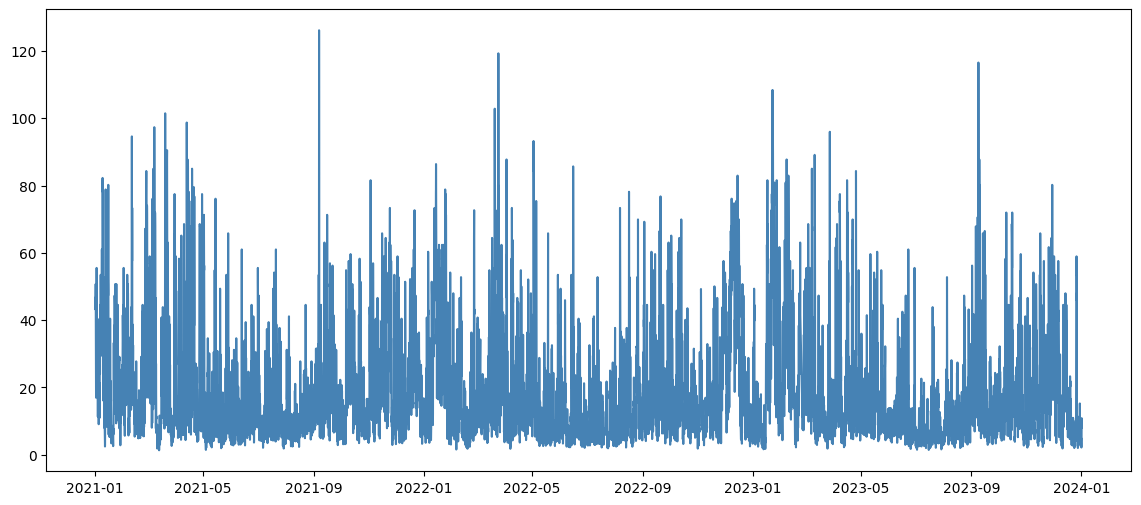

In [46]:
#  Initial visualisation of no2 to spot potential outliers
x = weather_aq.date_time.tolist()
y = weather_aq.no2.tolist()
plt.figure(figsize=(14, 6))
plt.plot(x,y, color='steelblue',label='no2')
plt.show()

**Observations:**
- Most recordings are below 100 but a few breach this
- Look more closely at the recordings above 100
- 100 is more than 2x the WHO recommended limit for no2


In [47]:
count_high_no2 = weather_aq[weather_aq['no2']>=100].shape[0]
count_high_no2

28

In [48]:
high_no2 = weather_aq[weather_aq['no2']>=100]
high_no2.iloc[:,:10].head(28)

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
1834,2021-03-19 22:00:00,3,520.71,56.77,100.08,52.987042,23.37,22.09,24.80,1.65
1835,2021-03-19 23:00:00,4,554.09,67.06,101.45,52.987042,21.70,25.13,28.00,1.49
5933,2021-09-06 17:00:00,4,420.57,32.63,102.82,18.060000,26.70,27.92,31.35,4.88
5934,2021-09-06 18:00:00,4,500.68,67.06,120.64,3.040000,40.53,32.64,36.46,6.59
5935,2021-09-06 19:00:00,4,560.76,91.20,126.12,0.050000,52.93,36.77,40.83,7.54
5936,2021-09-06 20:00:00,4,567.44,98.35,111.04,52.987042,51.98,39.20,43.31,6.65
10566,2022-03-20 18:00:00,4,527.38,80.47,102.82,2.010000,54.84,30.77,32.93,9.12
10567,2022-03-20 19:00:00,4,594.14,112.65,102.82,0.010000,66.76,35.38,38.09,11.53
10662,2022-03-24 18:00:00,4,614.17,119.81,102.82,1.590000,44.35,28.47,35.12,4.94
10663,2022-03-24 19:00:00,4,821.11,202.06,117.90,0.010000,58.65,43.77,51.06,6.59


**Observations:**
- air quality recordings are particularly bad on these dates (between 3 and 5)
- recommended levels of other pollutants are also high on these dates

##### Compare to data from nearby monitoring station (Hammersmith town centre)

#### Comparison data for high no2 readings:


In [49]:
# Data had to been downloaded in separate csvs to cover the whole time period
hammersmith_21 = pd.read_csv('data_unclean/2021_03_19_hammersmith.csv')
hammersmith_23 = pd.read_csv('data_unclean/2023_01_21_hammersmith.csv')

In [50]:
hammersmith_21.head()

,End Date,End Time,PM10,Status/units,NO,Status/units.1,NO2,Status/units.2,NOXasNO2,Status/units.3,O3,Status/units.4,PM25,Status/units.5,Unnamed: 14
0,19/03/2021,01:00:00,4.2,R ugm-3 (Ref.eq),4.49972,R ugm-3,14.81987,R ugm-3,21.71935,R ugm-3,55.26093,R ugm-3,4.4,R ugm-3 (BAM),NaN
1,19/03/2021,02:00:00,2.5,R ugm-3 (Ref.eq),3.19873,R ugm-3,11.79011,R ugm-3,16.69476,R ugm-3,57.08367,R ugm-3,1.4,R ugm-3 (BAM),NaN
2,19/03/2021,03:00:00,0.0,R ugm-3 (Ref.eq),2.71688,R ugm-3,14.81336,R ugm-3,18.97919,R ugm-3,58.82825,R ugm-3,2.4,R ugm-3 (BAM),NaN
3,19/03/2021,04:00:00,4.2,R ugm-3 (Ref.eq),2.89850,R ugm-3,11.84665,R ugm-3,16.29095,R ugm-3,55.77982,R ugm-3,5.4,R ugm-3 (BAM),NaN
4,19/03/2021,05:00:00,4.2,R ugm-3 (Ref.eq),3.25803,R ugm-3,12.50681,R ugm-3,17.50239,R ugm-3,53.12553,R ugm-3,6.4,R ugm-3 (BAM),NaN


In [51]:
hammersmith_23.head()

,End Date,End Time,PM10,Status/units,NO,Status/units.1,NO2,Status/units.2,NOXasNO2,Status/units.3,O3,Status/units.4,PM25,Status/units.5,Unnamed: 14
0,21/01/2023,01:00:00,16.7,R ugm-3 (Ref.eq),52.71684,R ugm-3,56.86151,R ugm-3,137.69286,R ugm-3,9.91391,R ugm-3,15.0,R ugm-3 (BAM),NaN
1,21/01/2023,02:00:00,10.8,R ugm-3 (Ref.eq),15.22804,R ugm-3,37.30372,R ugm-3,60.65306,R ugm-3,NaN,NaN,11.0,R ugm-3 (BAM),NaN
2,21/01/2023,03:00:00,9.2,R ugm-3 (Ref.eq),7.45250,R ugm-3,28.49807,R ugm-3,39.92507,R ugm-3,22.80995,R ugm-3,9.0,R ugm-3 (BAM),NaN
3,21/01/2023,04:00:00,12.5,R ugm-3 (Ref.eq),4.88848,R ugm-3,29.86670,R ugm-3,37.36227,R ugm-3,24.18564,R ugm-3,11.0,R ugm-3 (BAM),NaN
4,21/01/2023,05:00:00,8.3,R ugm-3 (Ref.eq),11.38565,R ugm-3,37.59459,R ugm-3,55.05234,R ugm-3,19.04028,R ugm-3,11.0,R ugm-3 (BAM),NaN


In [54]:
hammersmith_verified = pd.concat([hammersmith_21,hammersmith_23])
hammersmith_verified.columns

Index(['End Date', 'End Time', 'PM10', 'Status/units', 'NO', 'Status/units.1',
       'NO2', 'Status/units.2', 'NOXasNO2', 'Status/units.3', 'O3',
       'Status/units.4', 'PM25', 'Status/units.5', 'Unnamed: 14'],
      dtype='object')

In [55]:
hammersmith_verified.shape

(14476, 15)

In [56]:
hammersmith_verified = hammersmith_verified.drop(columns=['Status/units', 'Status/units.1', 'Status/units.2','Status/units.3', 'Status/units.4', 'Status/units.5','Unnamed: 14'])
hammersmith_verified.columns

Index(['End Date', 'End Time', 'PM10', 'NO', 'NO2', 'NOXasNO2', 'O3', 'PM25'], dtype='object')

In [57]:
hammersmith_verified = hammersmith_verified.rename(columns = {'End Date':'date','End Time':'time'})
hammersmith_verified.head(30)

,date,time,PM10,NO,NO2,NOXasNO2,O3,PM25
0,19/03/2021,01:00:00,4.2,4.49972,14.81987,21.71935,55.26093,4.4
1,19/03/2021,02:00:00,2.5,3.19873,11.79011,16.69476,57.08367,1.4
2,19/03/2021,03:00:00,0.0,2.71688,14.81336,18.97919,58.82825,2.4
3,19/03/2021,04:00:00,4.2,2.89850,11.84665,16.29095,55.77982,5.4
4,19/03/2021,05:00:00,4.2,3.25803,12.50681,17.50239,53.12553,6.4
5,19/03/2021,06:00:00,5.8,14.43691,30.48049,52.61677,44.82841,4.4
6,19/03/2021,07:00:00,8.3,78.86740,81.73365,202.66197,35.44363,9.4
7,19/03/2021,08:00:00,9.2,47.51021,54.52027,127.36824,24.41739,5.4
8,19/03/2021,09:00:00,23.3,78.74137,60.70365,181.43874,19.65266,13.4
9,19/03/2021,10:00:00,35.8,50.95728,46.90426,125.03767,37.20484,10.4


In [58]:
nans = hammersmith_verified.isna().sum()
nans

# There are some nans in date and time so these must be removed

date           2
time           4
PM10        1110
NO           428
NO2          434
NOXasNO2     434
O3          1182
PM25         952
dtype: int64

In [59]:
hammersmith_verified = hammersmith_verified.dropna(subset=['date', 'time'])

In [60]:
nans = hammersmith_verified.isna().sum()
nans

date           0
time           0
PM10        1106
NO           424
NO2          430
NOXasNO2     430
O3          1178
PM25         948
dtype: int64

In [ ]:
# Need to deal with nan vlaues in this data!

In [62]:
# Some times are in incorrect format 24:00:00 so these need to be changed to perform strptime function

hammersmith_verified['time'] = ['23:59:59' if x == '24:00:00' else x for x in hammersmith_verified['time']]
hammersmith_verified.head(30)

,date,time,PM10,NO,NO2,NOXasNO2,O3,PM25
0,19/03/2021,01:00:00,4.2,4.49972,14.81987,21.71935,55.26093,4.4
1,19/03/2021,02:00:00,2.5,3.19873,11.79011,16.69476,57.08367,1.4
2,19/03/2021,03:00:00,0.0,2.71688,14.81336,18.97919,58.82825,2.4
3,19/03/2021,04:00:00,4.2,2.89850,11.84665,16.29095,55.77982,5.4
4,19/03/2021,05:00:00,4.2,3.25803,12.50681,17.50239,53.12553,6.4
5,19/03/2021,06:00:00,5.8,14.43691,30.48049,52.61677,44.82841,4.4
6,19/03/2021,07:00:00,8.3,78.86740,81.73365,202.66197,35.44363,9.4
7,19/03/2021,08:00:00,9.2,47.51021,54.52027,127.36824,24.41739,5.4
8,19/03/2021,09:00:00,23.3,78.74137,60.70365,181.43874,19.65266,13.4
9,19/03/2021,10:00:00,35.8,50.95728,46.90426,125.03767,37.20484,10.4


In [63]:
# create new date_time column

hammersmith_verified['date_time'] = hammersmith_verified['date'] + ' ' + hammersmith_verified['time']
hammersmith_verified.head()

,date,time,PM10,NO,NO2,NOXasNO2,O3,PM25,date_time
0,19/03/2021,01:00:00,4.2,4.49972,14.81987,21.71935,55.26093,4.4,19/03/2021 01:00:00
1,19/03/2021,02:00:00,2.5,3.19873,11.79011,16.69476,57.08367,1.4,19/03/2021 02:00:00
2,19/03/2021,03:00:00,0.0,2.71688,14.81336,18.97919,58.82825,2.4,19/03/2021 03:00:00
3,19/03/2021,04:00:00,4.2,2.89850,11.84665,16.29095,55.77982,5.4,19/03/2021 04:00:00
4,19/03/2021,05:00:00,4.2,3.25803,12.50681,17.50239,53.12553,6.4,19/03/2021 05:00:00


In [64]:
# format date time

hammersmith_verified['date_time'] = hammersmith_verified['date_time'].apply(lambda row: datetime.strptime(row, '%d/%m/%Y %H:%M:%S'))


In [65]:
hammersmith_verified.head()

,date,time,PM10,NO,NO2,NOXasNO2,O3,PM25,date_time
0,19/03/2021,01:00:00,4.2,4.49972,14.81987,21.71935,55.26093,4.4,2021-03-19 01:00:00
1,19/03/2021,02:00:00,2.5,3.19873,11.79011,16.69476,57.08367,1.4,2021-03-19 02:00:00
2,19/03/2021,03:00:00,0.0,2.71688,14.81336,18.97919,58.82825,2.4,2021-03-19 03:00:00
3,19/03/2021,04:00:00,4.2,2.89850,11.84665,16.29095,55.77982,5.4,2021-03-19 04:00:00
4,19/03/2021,05:00:00,4.2,3.25803,12.50681,17.50239,53.12553,6.4,2021-03-19 05:00:00


In [66]:
# time was end time so subtract 1 hour from each time to match original data

hammersmith_verified['date_time'] = pd.to_datetime(hammersmith_verified['date_time'])
hammersmith_verified['date_time'] = hammersmith_verified['date_time'].apply(lambda dt: dt - timedelta(hours=1) if pd.notnull(dt) else dt)


In [67]:
# change 22:59:59 back to 23:00:00
hammersmith_verified['date_time'] = hammersmith_verified['date_time'].apply(
    lambda dt: dt.replace(hour=23, minute=0, second=0) if dt.time() == datetime.strptime('22:59:59', '%H:%M:%S').time() else dt
)

In [68]:
hammersmith_verified.head(30)

,date,time,PM10,NO,NO2,NOXasNO2,O3,PM25,date_time
0,19/03/2021,01:00:00,4.2,4.49972,14.81987,21.71935,55.26093,4.4,2021-03-19 00:00:00
1,19/03/2021,02:00:00,2.5,3.19873,11.79011,16.69476,57.08367,1.4,2021-03-19 01:00:00
2,19/03/2021,03:00:00,0.0,2.71688,14.81336,18.97919,58.82825,2.4,2021-03-19 02:00:00
3,19/03/2021,04:00:00,4.2,2.89850,11.84665,16.29095,55.77982,5.4,2021-03-19 03:00:00
4,19/03/2021,05:00:00,4.2,3.25803,12.50681,17.50239,53.12553,6.4,2021-03-19 04:00:00
5,19/03/2021,06:00:00,5.8,14.43691,30.48049,52.61677,44.82841,4.4,2021-03-19 05:00:00
6,19/03/2021,07:00:00,8.3,78.86740,81.73365,202.66197,35.44363,9.4,2021-03-19 06:00:00
7,19/03/2021,08:00:00,9.2,47.51021,54.52027,127.36824,24.41739,5.4,2021-03-19 07:00:00
8,19/03/2021,09:00:00,23.3,78.74137,60.70365,181.43874,19.65266,13.4,2021-03-19 08:00:00
9,19/03/2021,10:00:00,35.8,50.95728,46.90426,125.03767,37.20484,10.4,2021-03-19 09:00:00


In [69]:
hammersmith_verified = hammersmith_verified.drop(columns = ['date', 'time'])
hammersmith_verified.head()

,PM10,NO,NO2,NOXasNO2,O3,PM25,date_time
0,4.2,4.49972,14.81987,21.71935,55.26093,4.4,2021-03-19 00:00:00
1,2.5,3.19873,11.79011,16.69476,57.08367,1.4,2021-03-19 01:00:00
2,0.0,2.71688,14.81336,18.97919,58.82825,2.4,2021-03-19 02:00:00
3,4.2,2.89850,11.84665,16.29095,55.77982,5.4,2021-03-19 03:00:00
4,4.2,3.25803,12.50681,17.50239,53.12553,6.4,2021-03-19 04:00:00


In [70]:
# Combine high_no2 data with new data to compare
high_no2_combine = high_no2.iloc[:,:10].head(28)
combined_df = pd.merge(high_no2_combine, hammersmith_verified, left_on ='date_time', right_on='date_time', how='left')
combined_df

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,PM10,NO,NO2,NOXasNO2,O3,PM25
0,2021-03-19 22:00:00,3,520.71,56.77,100.08,52.987042,23.37,22.09,24.80,1.65,15.0,16.65711,43.81137,69.35192,31.39236,8.4
1,2021-03-19 23:00:00,4,554.09,67.06,101.45,52.987042,21.70,25.13,28.00,1.49,12.5,14.35536,33.12647,55.13772,31.34247,8.4
2,2021-09-06 17:00:00,4,420.57,32.63,102.82,18.060000,26.70,27.92,31.35,4.88,34.2,51.88236,92.67440,172.22624,46.84721,29.4
3,2021-09-06 18:00:00,4,500.68,67.06,120.64,3.040000,40.53,32.64,36.46,6.59,44.2,83.65729,133.06639,261.33912,4.65098,23.4
4,2021-09-06 19:00:00,4,560.76,91.20,126.12,0.050000,52.93,36.77,40.83,7.54,45.0,107.36041,117.11386,281.73085,7.94294,29.4
5,2021-09-06 20:00:00,4,567.44,98.35,111.04,52.987042,51.98,39.20,43.31,6.65,34.2,67.72104,97.07014,200.90761,18.56645,26.4
6,2022-03-20 18:00:00,4,527.38,80.47,102.82,2.010000,54.84,30.77,32.93,9.12,32.5,41.89144,70.45090,134.68355,46.58014,22.0
7,2022-03-20 19:00:00,4,594.14,112.65,102.82,0.010000,66.76,35.38,38.09,11.53,40.0,22.17863,53.59528,87.60204,36.32947,23.0
8,2022-03-24 18:00:00,4,614.17,119.81,102.82,1.590000,44.35,28.47,35.12,4.94,63.3,50.20949,106.22444,183.21125,20.99721,26.0
9,2022-03-24 19:00:00,4,821.11,202.06,117.90,0.010000,58.65,43.77,51.06,6.59,75.0,112.49847,160.11067,332.60592,17.63710,40.0


In [71]:
combined_df.columns

Index(['date_time', 'aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10',
       'nh3', 'PM10', 'NO', 'NO2', 'NOXasNO2', 'O3', 'PM25'],
      dtype='object')

In [72]:
# Drop columns to make is easier to compare no2 and pm readings
combined_df = combined_df.drop(columns=['co','no','o3','so2','nh3', 'NO','O3'])
combined_df

,date_time,aqi,no2,pm2_5,pm10,PM10,NO2,NOXasNO2,PM25
0,2021-03-19 22:00:00,3,100.08,22.09,24.80,15.0,43.81137,69.35192,8.4
1,2021-03-19 23:00:00,4,101.45,25.13,28.00,12.5,33.12647,55.13772,8.4
2,2021-09-06 17:00:00,4,102.82,27.92,31.35,34.2,92.67440,172.22624,29.4
3,2021-09-06 18:00:00,4,120.64,32.64,36.46,44.2,133.06639,261.33912,23.4
4,2021-09-06 19:00:00,4,126.12,36.77,40.83,45.0,117.11386,281.73085,29.4
5,2021-09-06 20:00:00,4,111.04,39.20,43.31,34.2,97.07014,200.90761,26.4
6,2022-03-20 18:00:00,4,102.82,30.77,32.93,32.5,70.45090,134.68355,22.0
7,2022-03-20 19:00:00,4,102.82,35.38,38.09,40.0,53.59528,87.60204,23.0
8,2022-03-24 18:00:00,4,102.82,28.47,35.12,63.3,106.22444,183.21125,26.0
9,2022-03-24 19:00:00,4,117.90,43.77,51.06,75.0,160.11067,332.60592,40.0


**Observations:**
- The combined data shows differences in measurements on most days
- There is a possible error in no2 data from 2021-03-19 as the measurement is more than 3x times the second set of data. These data points will be removed
- On most other days it is more in line, and often lower than the second set of data
- Slight differences could be due to locations of measuring station, i.e. the second set is from the town centre so traffic will be different
- There are also differences in data for pm2.5

In [73]:
weather_aq = weather_aq[~((weather_aq['date_time'] == '2021-03-19 22:00:00') | (weather_aq['date_time'] == '2021-03-19 23:00:00'))]


#### Unusual pm2.5 values

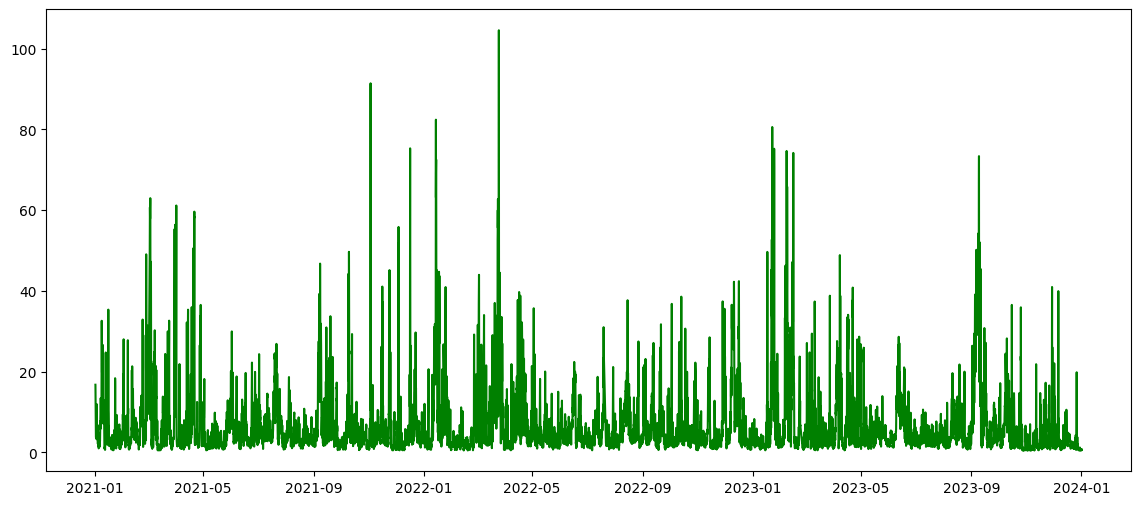

In [74]:
#  Initial visualisation of pm2.5 to spot potential outliers
x = weather_aq.date_time.tolist()
y = weather_aq.pm2_5.tolist()
plt.figure(figsize=(14, 6))
plt.plot(x,y, color='green',label='pm2.5')
plt.show()

In [75]:
small_values = weather_aq[weather_aq['pm2_5']<=1]

In [76]:
small_values.shape

(1305, 22)

In [78]:
small_values.head(50)

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,...,precipitation,rain,snowfall,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction,day,month,hour
86,2021-01-05 02:00:00,1,247.00,0.010000,9.08,45.06,5.72,0.97,1.85,0.35,...,0.0,0.0,0.00,1018.8,18.5,34.5,21,1,1,2
87,2021-01-05 03:00:00,1,250.34,0.020000,9.08,41.13,5.96,0.98,1.83,0.34,...,0.0,0.0,0.00,1018.7,18.9,34.5,21,1,1,3
241,2021-01-11 13:00:00,1,210.29,0.270000,8.91,75.10,3.87,0.99,1.90,0.29,...,0.0,0.0,0.00,1015.7,29.8,43.1,255,0,1,13
242,2021-01-11 14:00:00,1,206.95,0.140000,8.23,79.39,3.49,0.87,1.83,0.28,...,0.0,0.0,0.00,1014.9,27.0,41.2,251,0,1,14
243,2021-01-11 15:00:00,1,205.28,0.050000,7.97,79.39,3.28,0.90,1.97,0.30,...,0.0,0.0,0.00,1014.6,26.5,42.4,255,0,1,15
244,2021-01-11 16:00:00,1,205.28,0.010000,7.88,78.68,3.07,0.99,2.13,0.30,...,0.0,0.0,0.00,1014.2,25.9,43.0,254,0,1,16
253,2021-01-12 01:00:00,2,201.94,8.620351,2.79,83.69,1.54,1.00,1.31,0.10,...,0.2,0.2,0.00,1009.4,26.4,44.3,246,1,1,1
254,2021-01-12 02:00:00,2,200.27,8.620351,2.53,82.97,1.52,0.91,1.14,0.09,...,0.3,0.3,0.00,1008.6,26.3,43.5,248,1,1,2
255,2021-01-12 03:00:00,2,200.27,8.620351,2.46,80.82,1.58,0.85,1.04,0.09,...,0.7,0.7,0.00,1008.1,28.1,46.4,254,1,1,3
256,2021-01-12 04:00:00,1,198.60,8.620351,2.53,78.68,1.68,0.72,0.85,0.09,...,0.9,0.9,0.00,1007.7,28.1,46.0,261,1,1,4


**Observations:**
- Many of these smaller values were from a time period when the uk was in lock down so are not a true representation of what it is like on a usual day
- According to a report on road traffic (https://assets.publishing.service.gov.uk/media/633310c1d3bf7f567b3e61fb/road-traffic-estimates-in-great-britain-2021.pdf), traffic levels were significantly less than pre-pandemic levels throughout 2021
- Will look at data from 2022 and 2023 as traffic levels should be more accurate
- Unforuntunately the limitations of this data source mean that we cannot look at pre-pandemic levels
- It is clear from this data that reducing road traffic significantly improves air quality 

In [79]:
start_date = '2021-01-01'
end_date = '2021-12-31'

weather_aq_two_years = weather_aq[~weather_aq['date_time'].between(start_date,end_date)]

In [80]:
small_values = weather_aq_two_years[weather_aq_two_years['pm2_5']<=1]
small_values.head(50)

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,...,precipitation,rain,snowfall,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction,day,month,hour
8820,2022-01-05 00:00:00,1,270.37,8.620351,8.14,52.93,3.64,0.84,1.37,0.89,...,0.0,0.0,0.0,1006.0,19.6,36.1,284,2,1,0
8821,2022-01-05 01:00:00,1,270.37,8.620351,6.51,55.07,3.19,0.74,1.34,0.86,...,0.0,0.0,0.0,1006.2,19.6,35.9,283,2,1,1
8822,2022-01-05 02:00:00,1,267.03,8.620351,5.57,56.51,3.01,0.69,1.30,0.79,...,0.0,0.0,0.0,1006.6,20.3,37.3,283,2,1,2
8823,2022-01-05 03:00:00,1,267.03,8.620351,5.14,57.22,2.98,0.66,1.28,0.70,...,0.0,0.0,0.0,1007.0,20.8,37.6,280,2,1,3
8824,2022-01-05 04:00:00,1,267.03,8.620351,4.97,57.22,3.04,0.66,1.30,0.62,...,0.0,0.0,0.0,1007.3,21.3,38.3,281,2,1,4
8825,2022-01-05 05:00:00,1,263.69,8.620351,5.14,57.22,3.28,0.69,1.40,0.59,...,0.0,0.0,0.0,1007.8,20.4,37.3,284,2,1,5
8826,2022-01-05 06:00:00,1,267.03,8.620351,6.08,57.22,3.73,0.78,1.57,0.62,...,0.0,0.0,0.0,1008.0,19.6,36.4,287,2,1,6
8859,2022-01-06 15:00:00,2,247.00,0.070000,10.45,80.82,4.65,0.83,1.36,0.20,...,0.1,0.1,0.0,1013.0,23.6,40.5,201,3,1,15
8860,2022-01-06 16:00:00,1,243.66,0.010000,9.00,77.96,3.87,0.87,1.36,0.18,...,0.2,0.2,0.0,1012.1,24.9,42.9,202,3,1,16
8861,2022-01-06 17:00:00,1,247.00,8.620351,9.00,74.39,3.70,0.91,1.31,0.15,...,0.3,0.3,0.0,1011.4,24.6,42.3,205,3,1,17


In [81]:
small_values.tail(50)

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,...,precipitation,rain,snowfall,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction,day,month,hour
25967,2023-12-30 11:00:00,2,236.99,0.030000,7.54,73.67,2.59,0.82,1.21,0.17,...,0.2,0.2,0.0,1005.7,30.6,48.2,200,5,12,11
25968,2023-12-30 12:00:00,2,233.65,0.040000,6.25,75.10,2.18,0.64,1.02,0.17,...,0.1,0.1,0.0,1004.4,31.1,47.5,200,5,12,12
25969,2023-12-30 13:00:00,2,230.31,0.050000,5.44,77.96,1.74,0.50,0.82,0.16,...,0.1,0.1,0.0,1003.6,28.2,43.4,203,5,12,13
25970,2023-12-30 14:00:00,2,230.31,0.040000,5.36,79.39,1.74,0.50,0.87,0.17,...,0.1,0.1,0.0,1002.4,27.8,42.9,201,5,12,14
25971,2023-12-30 15:00:00,2,226.97,0.020000,5.27,77.96,1.77,0.52,0.97,0.19,...,0.0,0.0,0.0,1001.5,28.6,45.0,197,5,12,15
25972,2023-12-30 16:00:00,2,226.97,8.620351,5.23,76.53,1.74,0.57,1.09,0.21,...,0.0,0.0,0.0,1000.7,29.9,47.6,193,5,12,16
25973,2023-12-30 17:00:00,2,226.97,8.620351,5.36,75.10,1.68,0.61,1.17,0.22,...,0.0,0.0,0.0,999.5,31.8,49.7,190,5,12,17
25974,2023-12-30 18:00:00,2,226.97,8.620351,5.40,75.10,1.62,0.59,1.13,0.22,...,0.0,0.0,0.0,998.2,33.0,52.5,187,5,12,18
25975,2023-12-30 19:00:00,2,226.97,8.620351,5.23,75.10,1.68,0.59,1.11,0.22,...,0.0,0.0,0.0,997.1,34.0,53.4,185,5,12,19
25976,2023-12-30 20:00:00,2,226.97,8.620351,4.84,75.82,1.65,0.66,1.24,0.23,...,0.1,0.1,0.0,996.1,34.4,53.9,187,5,12,20


In [82]:
small_values.shape

(845, 22)

In [83]:
large_values = weather_aq_two_years[weather_aq_two_years['pm2_5']>=70]
large_values.shape

(25, 22)

In [84]:
large_values

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,...,precipitation,rain,snowfall,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction,day,month,hour
9046,2022-01-14 10:00:00,5,1041.41,271.80,75.40,1.030000,56.27,71.93,76.07,4.02,...,0.0,0.0,0.0,1036.4,4.1,8.9,52,4,1,10
9047,2022-01-14 11:00:00,5,1081.47,286.10,76.77,2.100000,40.05,78.46,82.78,1.93,...,0.0,0.0,0.0,1035.9,0.8,1.1,243,4,1,11
9048,2022-01-14 12:00:00,5,1081.47,286.10,78.14,2.860000,35.76,82.39,86.78,1.20,...,0.0,0.0,0.0,1035.2,2.3,4.8,39,4,1,12
9052,2022-01-14 16:00:00,5,841.14,189.54,85.00,0.580000,46.73,70.40,74.62,1.25,...,0.0,0.0,0.0,1033.6,5.5,9.8,67,4,1,16
9053,2022-01-14 17:00:00,5,854.49,214.58,82.25,52.987042,54.84,71.05,75.43,2.79,...,0.0,0.0,0.0,1033.5,7.0,7.2,69,4,1,17
9054,2022-01-14 18:00:00,5,881.20,243.19,82.25,52.987042,70.57,72.04,76.31,4.88,...,0.0,0.0,0.0,1033.4,6.6,10.8,49,4,1,18
9055,2022-01-14 19:00:00,5,921.25,261.07,80.88,52.987042,79.15,72.51,76.14,6.27,...,0.0,0.0,0.0,1033.0,7.0,14.5,55,4,1,19
10675,2022-03-25 07:00:00,5,433.92,9.95,67.17,4.780000,15.26,72.17,75.89,0.46,...,0.0,0.0,0.0,1030.4,9.6,17.4,56,4,3,7
10676,2022-03-25 08:00:00,5,494.00,36.21,66.49,11.350000,22.17,91.18,95.21,0.75,...,0.0,0.0,0.0,1030.6,7.1,16.8,49,4,3,8
10677,2022-03-25 09:00:00,5,540.73,56.77,66.49,17.170000,28.13,104.54,108.95,1.20,...,0.0,0.0,0.0,1031.1,8.2,12.6,52,4,3,9


**Observations:**
- Some of these readings are above usual levels but generally occur within rush hour
- No significant events (e.g. fires) happened on these dates in the local area

In [85]:
large_and_small = pd.concat([small_values, large_values])


In [86]:
large_and_small.shape

(870, 22)

In [87]:
correlation_matrix = large_and_small.iloc[:,1:-3].corr()
correlation_matrix

,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,temp_C,percent_humidity,precipitation,rain,snowfall,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction
aqi,1.000000,0.634757,0.601844,0.635435,0.022021,0.584397,0.710268,0.712111,0.402496,-0.120782,0.102223,0.003092,0.004405,-0.017584,0.172614,-0.181113,-0.225753,-0.389340
co,0.634757,1.000000,0.960406,0.930764,-0.352877,0.913963,0.878254,0.877178,0.777253,-0.402254,0.180182,-0.059677,-0.060296,0.003699,0.367877,-0.316653,-0.346808,-0.313309
no,0.601844,0.960406,1.000000,0.893830,-0.322923,0.929154,0.817780,0.817313,0.790105,-0.338925,0.235928,-0.047354,-0.047061,-0.007710,0.325733,-0.344102,-0.352515,-0.285517
no2,0.635435,0.930764,0.893830,1.000000,-0.484958,0.920667,0.931359,0.929159,0.742533,-0.272484,0.198795,-0.058066,-0.057797,-0.008240,0.381899,-0.444142,-0.474295,-0.326210
o3,0.022021,-0.352877,-0.322923,-0.484958,1.000000,-0.311186,-0.463277,-0.458783,-0.151482,0.083761,-0.372179,0.009715,0.009735,0.000498,-0.055706,0.448514,0.374361,-0.034101
so2,0.584397,0.913963,0.929154,0.920667,-0.311186,1.000000,0.835314,0.836041,0.870084,-0.277067,0.152721,-0.062269,-0.062407,-0.003029,0.379335,-0.366083,-0.408616,-0.304642
pm2_5,0.710268,0.878254,0.817780,0.931359,-0.463277,0.835314,1.000000,0.999512,0.662573,-0.227132,0.147278,-0.058973,-0.058565,-0.010195,0.376789,-0.371512,-0.403819,-0.334788
pm10,0.712111,0.877178,0.817313,0.929159,-0.458783,0.836041,0.999512,1.000000,0.664035,-0.230967,0.143808,-0.064916,-0.064474,-0.011119,0.380874,-0.368628,-0.400018,-0.335654
nh3,0.402496,0.777253,0.790105,0.742533,-0.151482,0.870084,0.662573,0.664035,1.000000,-0.246421,-0.118403,-0.140142,-0.140621,-0.004562,0.450638,-0.276207,-0.341626,-0.124552
temp_C,-0.120782,-0.402254,-0.338925,-0.272484,0.083761,-0.277067,-0.227132,-0.230967,-0.246421,1.000000,-0.347173,0.065123,0.070565,-0.068764,-0.051002,-0.061935,-0.200987,0.189538


<Axes: >

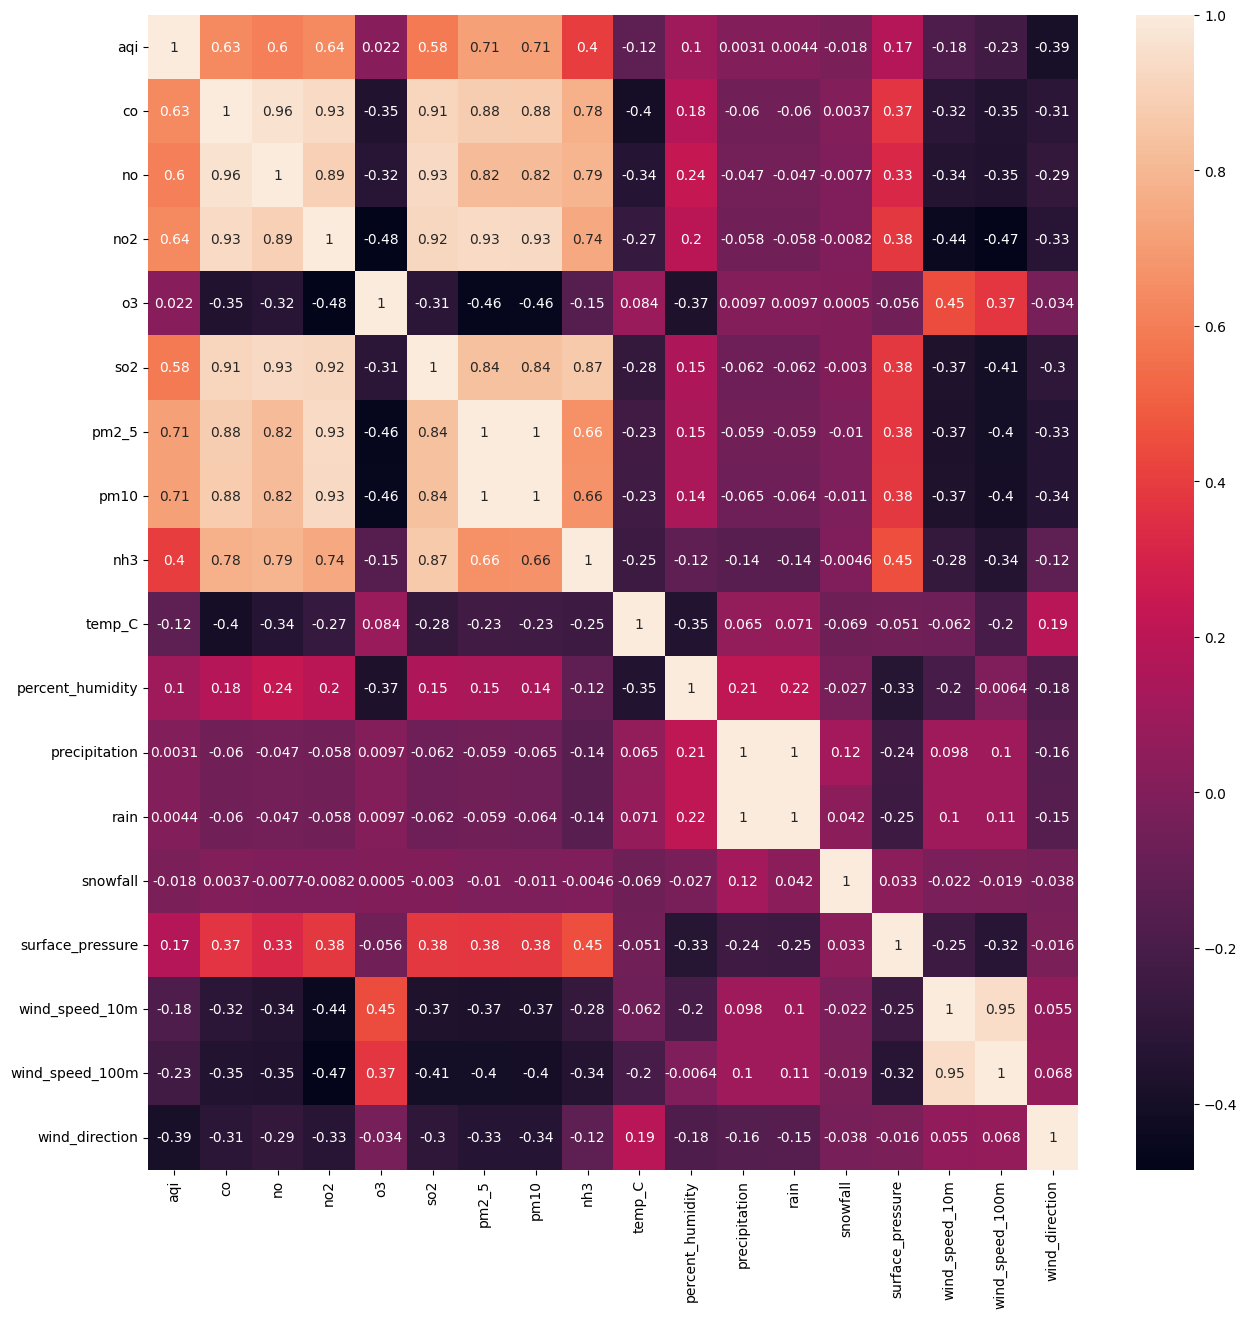

In [88]:
plt.figure(figsize = (15,15))
sns.heatmap(data = correlation_matrix, annot = True)

- The heatmap shows a correlation in this data between pm2.5 and other pollutants which should mean that there were not innacuracies in meter readings.
- There is a negative correlation between particulate matter and wind speed
- Large values are under-rpresented in this data so heatmap may not be completely accurate. But correlation is similar to that within heatmap of entire dataset below.
- Therefore, high values may be down to high traffic

### Visualising NO2 data by day

In [96]:
weather_aq['date_time'] = pd.to_datetime(weather_aq['date_time'])

# Use a temporary DataFrame for resampling by day
temp_df = weather_aq.set_index('date_time')
daily_data = temp_df.resample('D').mean().reset_index()

daily_data.head()



,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,...,precipitation,rain,snowfall,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction,day,month,hour
0,2021-01-01,1.916667,314.315000,11.092500,45.410833,1.699167,17.872500,9.675833,10.928333,0.888333,...,0.033333,0.033333,0.0,1011.216667,8.683333,16.400000,300.666667,4.0,1.0,17.5
1,2021-01-02,1.333333,289.977083,7.822917,34.516250,13.347500,13.712083,6.353333,7.679167,0.727083,...,0.000000,0.000000,0.0,1014.579167,9.104167,17.562500,321.708333,5.0,1.0,11.5
2,2021-01-03,1.125000,294.845833,3.508333,30.002500,9.265000,12.012917,5.781667,6.535000,0.675833,...,0.025000,0.025000,0.0,1016.262500,13.083333,25.229167,40.125000,6.0,1.0,11.5
3,2021-01-04,1.000000,276.764167,0.270417,16.545417,30.358333,7.579583,2.278333,3.378333,0.352917,...,0.095833,0.095833,0.0,1018.087500,22.087500,37.337500,30.375000,0.0,1.0,11.5
4,2021-01-05,1.000000,260.353333,0.202500,16.657500,33.126250,8.225000,1.749167,2.325000,0.352500,...,0.087500,0.087500,0.0,1018.687500,19.829167,33.654167,20.625000,1.0,1.0,11.5


In [97]:
daily_data.tail()

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,...,precipitation,rain,snowfall,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction,day,month,hour
1091,2023-12-28,2.000,228.920000,6.120665,4.790417,80.645000,1.971667,0.952917,2.398333,0.145000,...,0.016667,0.016667,0.0,1004.087500,33.183333,51.325000,226.208333,3.0,12.0,11.5
1092,2023-12-29,1.625,247.836250,5.833984,6.913333,63.777917,2.578333,0.593333,0.953750,0.278333,...,0.062500,0.062500,0.0,1005.762500,23.008333,38.095833,241.958333,4.0,12.0,11.5
1093,2023-12-30,1.750,233.649167,6.473180,6.742500,69.349583,2.329583,0.697083,1.195000,0.208750,...,0.150000,0.150000,0.0,1003.604167,24.795833,41.137500,202.875000,5.0,12.0,11.5
1094,2023-12-31,2.000,229.755417,5.778567,4.172083,71.823333,1.547917,0.542917,0.785000,0.175000,...,0.316667,0.316667,0.0,987.704167,28.845833,45.437500,220.208333,6.0,12.0,11.5
1095,2024-01-01,2.000,234.934615,6.014089,5.494615,68.277692,2.589231,0.586923,1.091538,0.389231,...,0.000000,0.000000,0.0,999.253846,23.392308,38.869231,248.846154,0.0,1.0,6.0


In [98]:
daily_data = daily_data.iloc[:-1,:]

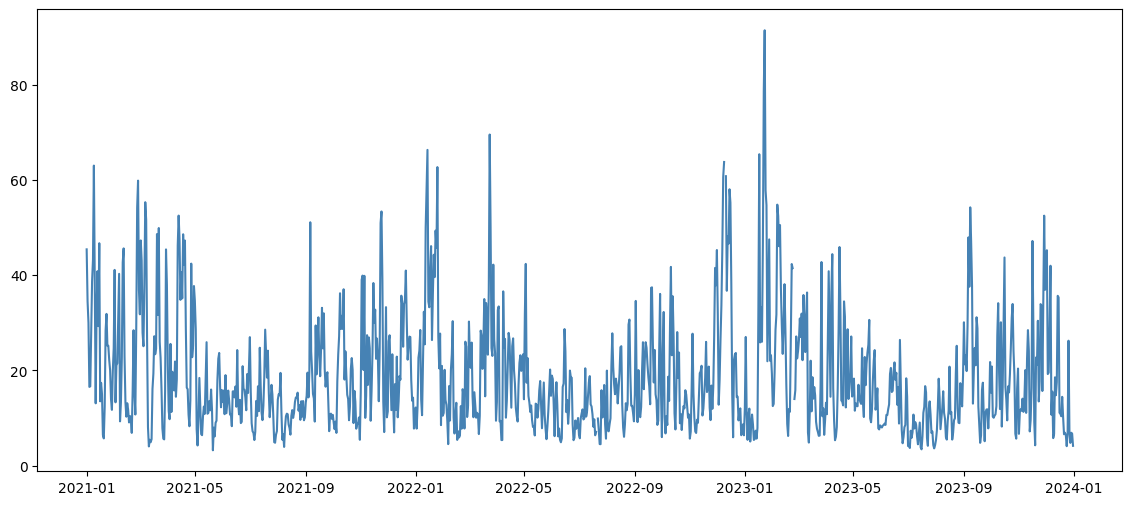

In [99]:
x = daily_data.date_time.tolist()
y = daily_data.no2.tolist()
plt.figure(figsize=(14, 6))
plt.plot(x,y, color='steelblue',label='no2')
plt.show()

### Visualising NO2 data by month

In [101]:
monthly_data = temp_df.resample('ME').mean().reset_index()

monthly_data.head()

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,...,precipitation,rain,snowfall,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction,day,month,hour
0,2021-01-31,1.300847,275.025042,8.520151,25.975169,33.870777,10.888150,5.583941,6.493658,0.761879,...,0.159605,0.150000,0.006723,1010.005085,15.137994,26.927260,193.747175,3.218927,1.0,11.601695
1,2021-02-28,1.468750,270.657798,11.630169,23.557649,50.975559,10.041726,7.763393,9.406190,2.177828,...,0.060417,0.054018,0.004479,1013.890625,16.950744,29.135417,157.529762,3.000000,2.0,11.500000
2,2021-03-31,1.944744,277.299272,12.274277,25.748046,54.528345,9.610243,11.430943,13.520216,1.584137,...,0.044205,0.044205,0.000000,1020.713747,15.882345,25.732345,191.919137,2.803235,3.0,11.470350
3,2021-04-30,1.938889,266.349833,10.383798,26.771889,64.273208,10.496153,8.561708,10.203486,1.550792,...,0.015139,0.013889,0.000875,1021.837500,12.633889,19.937500,129.883333,3.033333,4.0,11.500000
4,2021-05-31,1.330645,208.571989,3.564758,13.764798,62.113268,5.507661,3.779382,4.904637,0.556344,...,0.115995,0.115995,0.000000,1009.122177,15.809409,24.951613,203.577957,3.064516,5.0,11.500000


In [102]:
monthly_data.tail()

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,...,precipitation,rain,snowfall,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction,day,month,hour
32,2023-09-30,2.027260,267.028881,9.347170,21.465481,57.765812,8.791148,13.620990,17.213472,1.050201,...,0.082783,0.082783,0.000000,1012.792539,13.165423,21.439024,169.872310,3.037303,9.0,11.483501
33,2023-10-31,1.574697,264.041292,7.429110,18.857739,45.012802,6.786528,6.157524,8.414522,0.489813,...,0.123688,0.123688,0.000000,1005.871736,14.383849,24.493540,196.773890,2.931359,10.0,11.515478
34,2023-11-30,1.468056,260.501431,7.295233,20.686861,42.027551,7.007806,3.547736,4.644292,0.464014,...,0.124861,0.124861,0.000000,1003.448333,16.184722,28.560556,229.672222,2.966667,11.0,11.500000
35,2023-12-31,1.633065,261.685444,7.717317,16.107849,51.924658,5.940833,3.240860,4.806169,0.457796,...,0.106183,0.105108,0.000753,1009.917339,20.038038,34.130511,229.131720,3.193548,12.0,11.500000
36,2024-01-31,2.000000,234.934615,6.014089,5.494615,68.277692,2.589231,0.586923,1.091538,0.389231,...,0.000000,0.000000,0.000000,999.253846,23.392308,38.869231,248.846154,0.000000,1.0,6.000000


In [103]:
monthly_data = monthly_data.iloc[:-1,:]

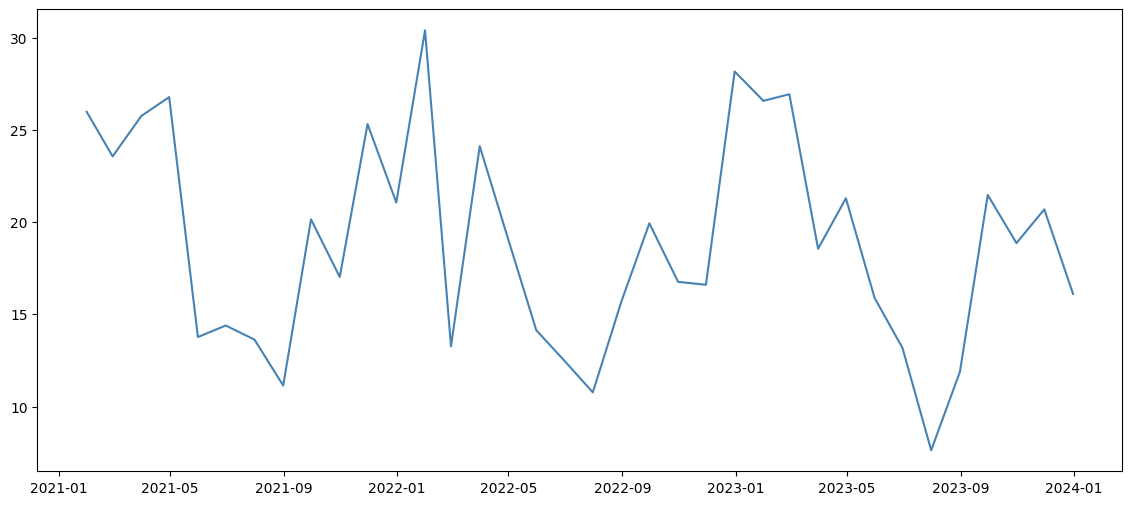

In [105]:
x = monthly_data.date_time.tolist()
y = monthly_data.no2.tolist()
plt.figure(figsize=(14, 6))
plt.plot(x,y, color='steelblue',label='no2')
plt.show()

**Observations:**
- NO2 levels peak in winter and dip in summer
- There is only 1 reading for January 2024 so this average is not accurate

### Yearly averages for pollutants in Hammersmith

In [106]:
# Average values per year

yearly_data = temp_df.resample('YE').mean().reset_index()
yearly_data.iloc[:-1,:10]

,date_time,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2021-12-31,1.444852,259.747147,8.655374,19.798417,50.213961,8.054678,6.729827,8.383847,0.883260
1,2022-12-31,1.489292,237.229111,8.491890,18.461483,53.985139,7.884188,6.970241,8.918537,0.969437
2,2023-12-31,1.731898,251.627885,8.703872,18.114510,54.761234,7.682481,6.754024,8.673863,0.820755


**Observations**
- Average levels of no2 have gone down slightly over past 3 years but are still above WHO guidelines
- Levels of pm2.5 have fluctuated and were higher in 2023 than 2021

### Current performance against air quality targets

In [107]:
NO2_above_UK_target = weather_aq[weather_aq['no2'] >= 40]
NO2_above_WHO_target = weather_aq[weather_aq['no2'] >= 10]

In [108]:
NO2_above_UK_target.no2.describe()


count    2835.000000
mean       54.799580
std        13.093135
min        40.100000
25%        45.240000
50%        51.410000
75%        61.010000
max       126.120000
Name: no2, dtype: float64

In [109]:
NO2_above_WHO_target.no2.describe()

count    16667.000000
mean        25.695701
std         15.965196
min         10.020000
25%         13.880000
50%         20.050000
75%         32.900000
max        126.120000
Name: no2, dtype: float64

In [110]:
percentage_exceeding_uk = len(NO2_above_UK_target.no2) / len(weather_aq.no2) * 100
percentage_exceeding_uk

10.897978011839779

In [111]:
percentage_exceeding_WHO = len(NO2_above_WHO_target.no2)/ len(weather_aq.no2) * 100
percentage_exceeding_WHO

64.06934727454447

**In the past 3 years, almost 11% of the air quality recordings at this location exceeded the UK's target for NO2 and more than 64% exceeded the WHO's 2021 air quality guidelines.**

In [112]:
pm25_above_UK_target = weather_aq[weather_aq['pm2_5'] >= 10]
pm25_above_WHO_target = weather_aq[weather_aq['pm2_5'] >= 5]

In [113]:
pm25_above_UK_target.pm2_5.describe()

count    4804.000000
mean       20.164230
std        11.306721
min        10.000000
25%        12.360000
50%        16.240000
75%        23.785000
max       104.540000
Name: pm2_5, dtype: float64

In [114]:
pm25_above_WHO_target.pm2_5.describe()

count    10546.000000
mean        12.976480
std         10.126586
min          5.000000
25%          6.540000
50%          9.310000
75%         15.287500
max        104.540000
Name: pm2_5, dtype: float64

In [115]:
percentage_exceeding_uk_pm25 = len(pm25_above_UK_target.pm2_5) / len(weather_aq.pm2_5) * 100
percentage_exceeding_uk_pm25

18.466979318828322

In [116]:
percentage_exceeding_WHO_pm25 = len(pm25_above_WHO_target.pm2_5) / len(weather_aq.pm2_5) * 100
percentage_exceeding_WHO_pm25

40.53970938725302

18% of air quality recordings at this station have breached the UK's target for pm2.5 and over 40% have breached WHO guidelines.

### Average levels of NO2

In [117]:
mean_no2 = statistics.mean(weather_aq.no2)
mean_no2

18.787384869685553

In [118]:
median_no2 = statistics.median(weather_aq.no2)
median_no2

13.37

**Both the mean and median levels of NO2 exceed the WHO's guidelines but are below UK targets.**

## Heatmap to show correlation between pollutants and weather

<Axes: >

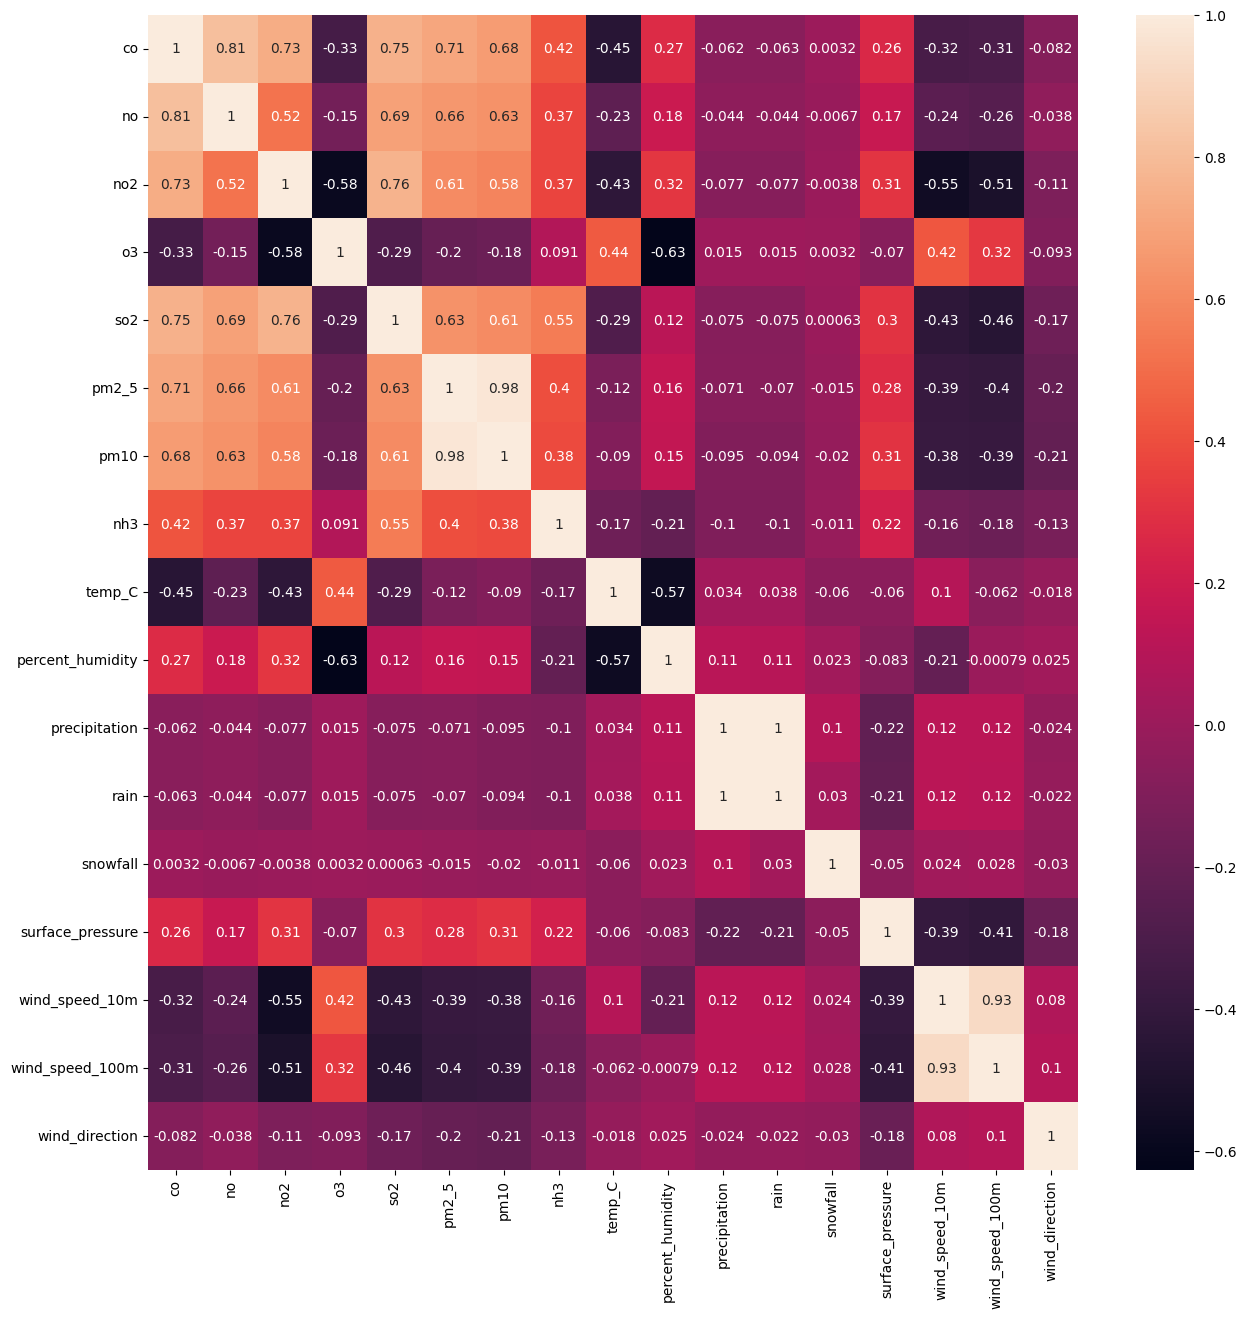

In [119]:
# heatmap to look at data on days where no2 is high and find correlations

# high_no2 = weather_aq[weather_aq['no2']>40].iloc[:,2:-3]

heatmap_data = weather_aq.iloc[:,2:-3]
plt.figure(figsize = (15,15))
# correlation_matrix = high_no2.corr()
correlation_matrix = heatmap_data.corr()
# seaborn adds heatmap to visually highlight significant values in the matrix
sns.heatmap(data = correlation_matrix, annot = True)

**The heatmap shows the correlation between different pollutants and the weather.**
- There is a strong negative correlation between ozone (o3) and humidity (low humidity tends to mean ozone levels are higher)
- There is a strong correlation between different pollutant levels. Generally when there are high levels of one pollutant, the others are also high (with the exception of ozone)
- Ozone levels tend to be higher if the temperature is higher and it is more humid
- There is a near perfect correlation between pm2_5 and pm10. If pm2_5 is high, pm10 is high

**Why are ozone levels lower when the others are high?**

Photochemical Reactions:
- Ozone is a secondary pollutant, meaning it is not directly emitted but formed through photochemical reactions in the atmosphere.
- These reactions typically involve precursor pollutants like nitrogen oxides (NOₓ) and volatile organic compounds (VOCs) in the presence of sunlight.
- High levels of NO can actually consume ozone through a reaction that converts NO to NO₂ and O₃ to O₂.

Sources and Formation:
- NOₓ is primarily emitted from combustion processes, such as vehicle exhaust and industrial activities.
- Ozone formation is more pronounced in sunny conditions, which means its levels can be higher in rural areas downwind of urban centers (where precursor pollutants have had time to react).

Temporal Patterns:
- There are often diurnal and seasonal patterns in the levels of these pollutants.
- For instance, NO levels are typically higher during rush hours due to traffic emissions, while ozone levels peak in the afternoon when sunlight is most intense.

## Correlation between time of day and no2 levels


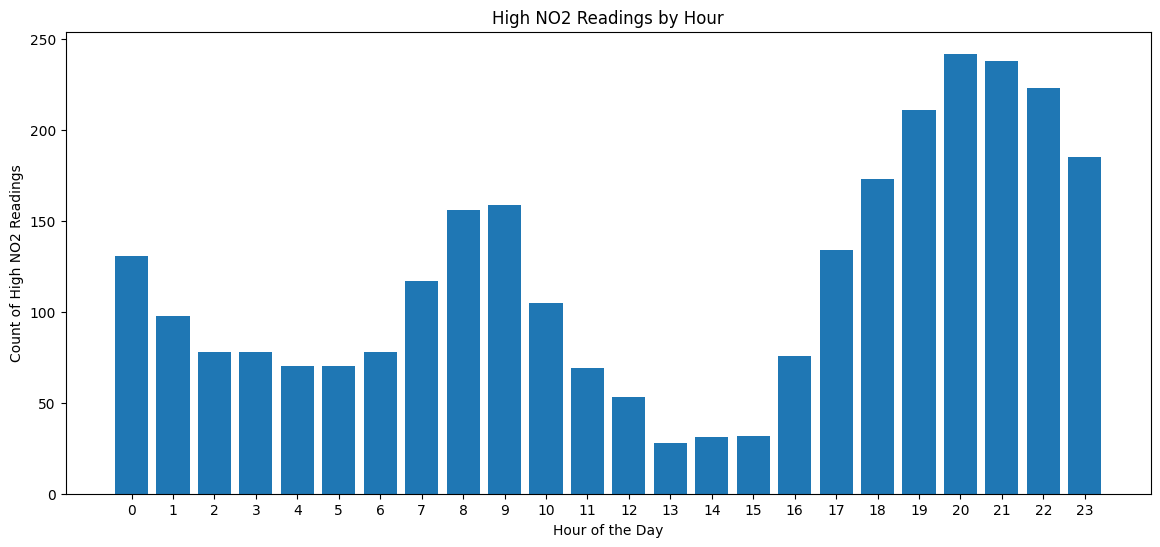

In [120]:
high_no2 = weather_aq[weather_aq['no2'] > 40]

high_no2_by_hour = high_no2.groupby('hour').no2.count().to_frame()
x = high_no2_by_hour.index.tolist()
y = high_no2_by_hour.no2.tolist()

plt.figure(figsize=(14, 6))
plt.bar(x, y)

# Set x-ticks and labels
plt.xticks(ticks=x, labels=[str(hour) for hour in x])

# Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Count of High NO2 Readings')
plt.title('High NO2 Readings by Hour')

# Show plot
plt.show()


This bar chart shows which times of day the UK limit for no2 is most frequently breached. 
There is a peak between 7 and 10 and a larger peak between 5pm and midnight. 


## Average no2 readings by the hour

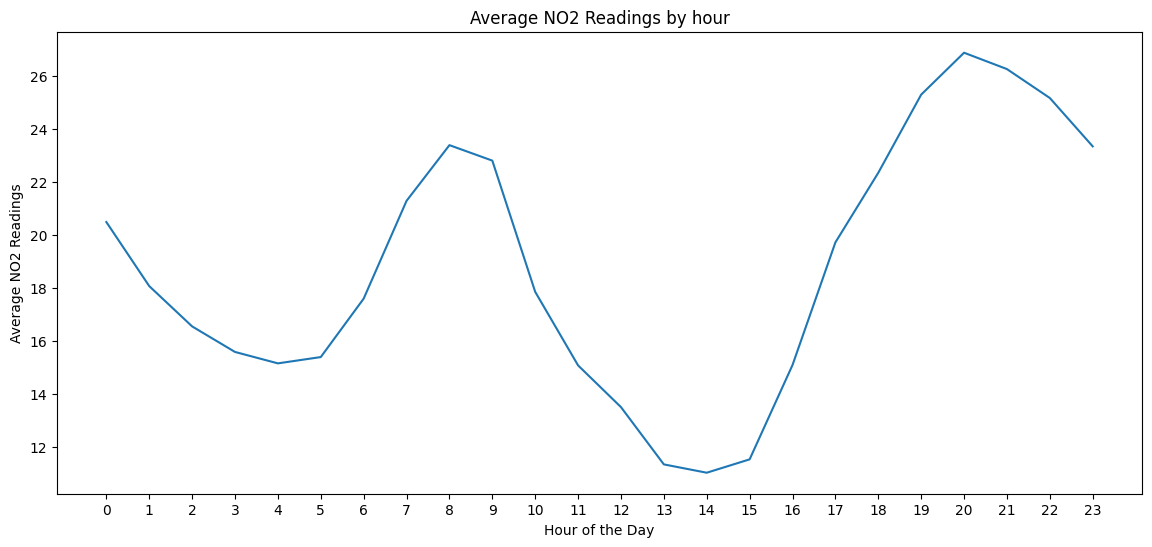

In [121]:
average_by_hour = weather_aq.groupby('hour').no2.mean().to_frame()
x = average_by_hour.index.tolist()
y = average_by_hour.no2.tolist()

plt.figure(figsize=(14, 6))
plt.plot(x, y)

plt.xticks(ticks=x, labels=[str(hour) for hour in x])

plt.xlabel('Hour of the Day')
plt.ylabel('Average NO2 Readings')
plt.title('Average NO2 Readings by hour')

# Show plot
plt.show()

## Correlation between month and pollutant levels

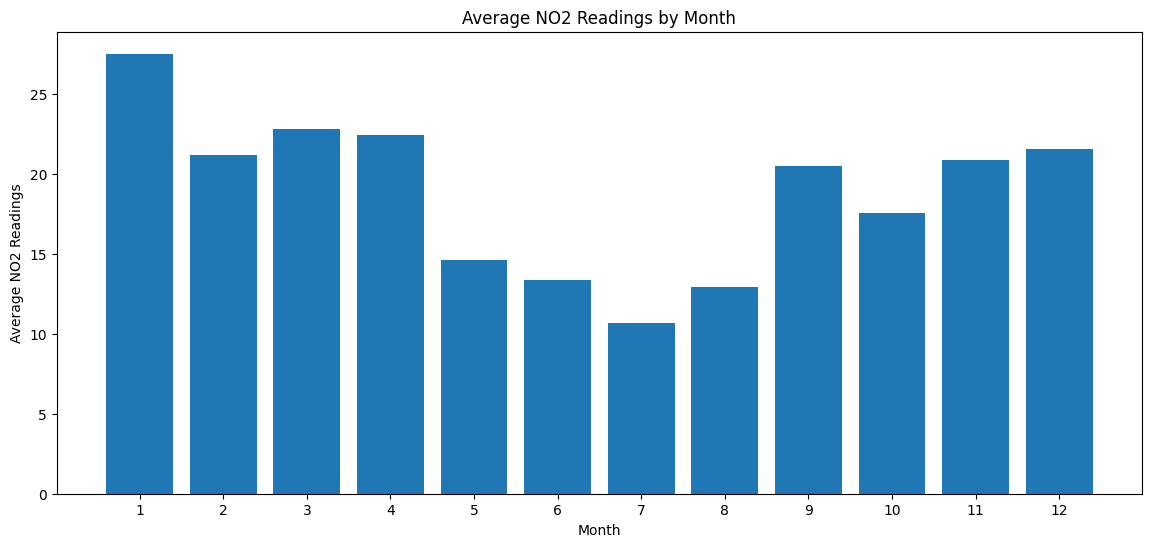

In [122]:
average_by_month = weather_aq.groupby('month').no2.mean().to_frame()
x = average_by_month.index.tolist()
y = average_by_month.no2.tolist()

plt.figure(figsize=(14, 6))
plt.bar(x, y)

# Set x-ticks and labels
plt.xticks(ticks=x, labels=[str(month) for month in x])

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Average NO2 Readings')
plt.title('Average NO2 Readings by Month')

# Show plot
plt.show()

**Summary**
- Pollutant levels are generally lower during summer months
- This could be linked to school holidays as well as more people driving when weather is colder (cannot only be school holidays as May and June also lower)
- How can we encourage less car use in the winter months?

## Correlation between day of the week and pollutant levels

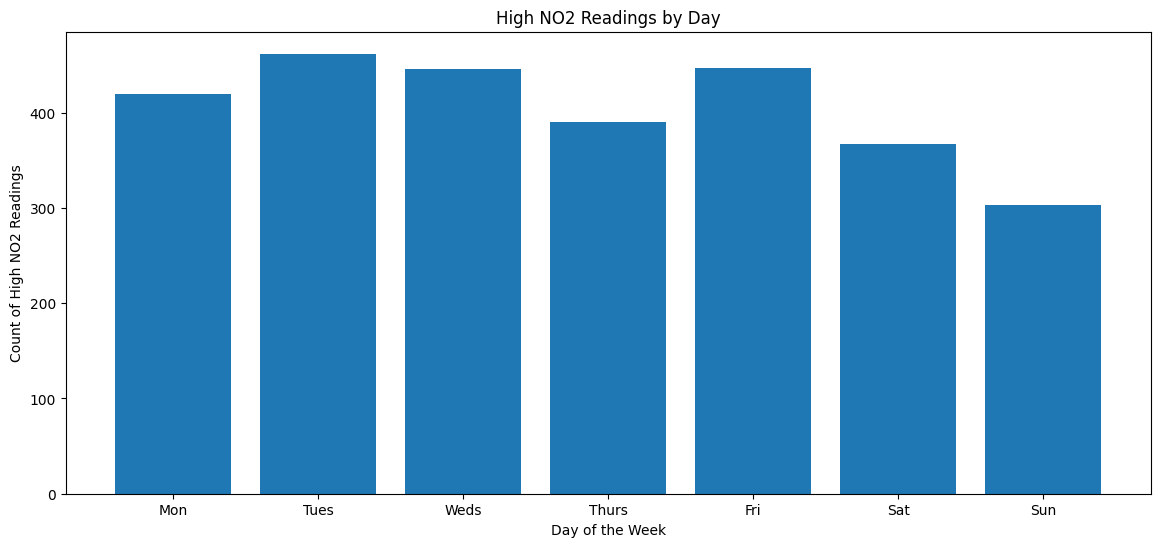

In [123]:
high_no2 = weather_aq[weather_aq['no2'] > 40]

high_no2_by_day = high_no2.groupby('day').no2.count().to_frame()
x = high_no2_by_day.index.tolist()
y = high_no2_by_day.no2.tolist()

plt.figure(figsize=(14, 6))
plt.bar(x, y)

days = ['Mon','Tues','Weds', 'Thurs', 'Fri', 'Sat', 'Sun']
plt.xticks(ticks=x, labels=[str(day) for day in days])


plt.xlabel('Day of the Week')
plt.ylabel('Count of High NO2 Readings')
plt.title('High NO2 Readings by Day')


plt.show()

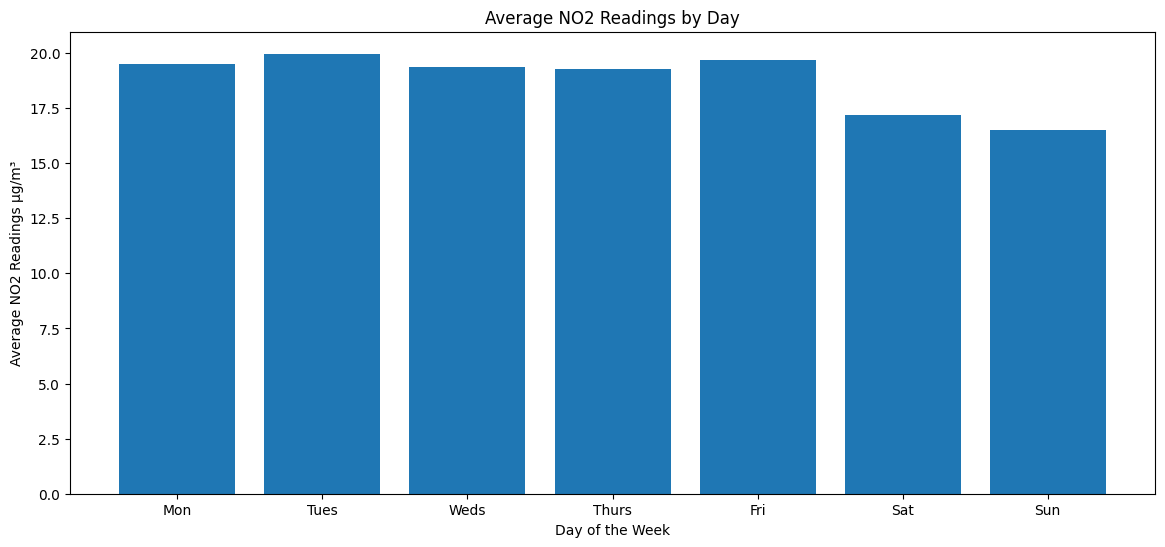

In [124]:
average_no2_by_day = weather_aq.groupby('day').no2.mean().to_frame()
x = average_no2_by_day.index.tolist()
y = average_no2_by_day.no2.tolist()

plt.figure(figsize=(14, 6))
plt.bar(x, y)

plt.xticks(ticks=x, labels=[str(day) for day in days])

plt.xlabel('Day of the Week')
plt.ylabel('Average NO2 Readings μg/m³')
plt.title('Average NO2 Readings by Day')


plt.show()

WHO recommended levels are 10 μg/m³, UK recommended levels are 40μg/m³.

## Correlation between temperature and pollutant levels

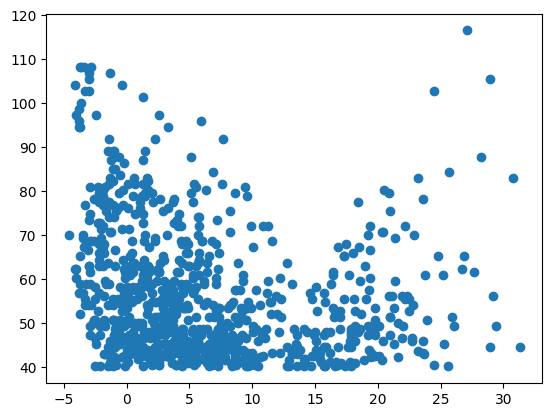

In [125]:
# Look at correlation in 2023 and just where pollutant levels are high so that graphs are easier to read.
weather_2023 = weather_aq[(weather_aq['date_time'] >= '2023-01-01') & (weather_aq['date_time'] <= '2023-12-01')&(weather_aq.no2>=40)]
x = weather_2023.temp_C.tolist()
y_1 = weather_2023.no2.tolist()


plt.scatter(x,y_1)
plt.show()

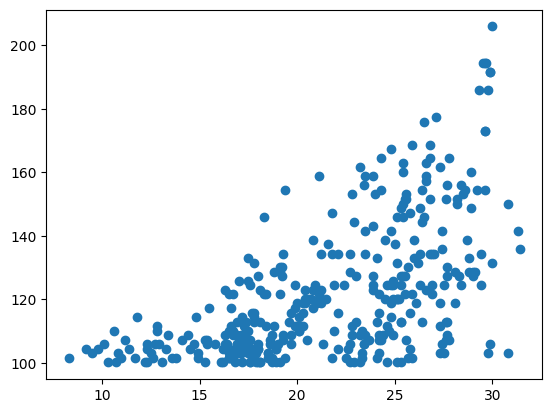

In [126]:
weather_2023 = weather_aq[(weather_aq['date_time'] >= '2023-01-01') & (weather_aq['date_time'] <= '2023-12-01')&(weather_aq.o3>=100)]
x = weather_2023.temp_C.tolist()
y_2 = weather_2023.o3.tolist()
plt.scatter(x,y_2)
plt.show()

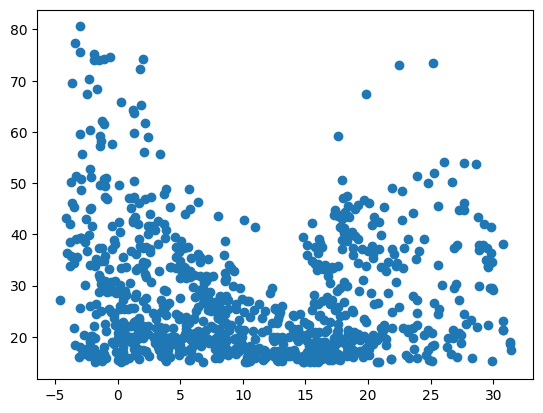

In [127]:
weather_2023 = weather_aq[(weather_aq['date_time'] >= '2023-01-01') & (weather_aq['date_time'] <= '2023-12-01')&(weather_aq.pm2_5>=15)]
x = weather_2023.temp_C.tolist()
y_3 = weather_2023.pm2_5.tolist()
plt.scatter(x,y_3)
plt.show()

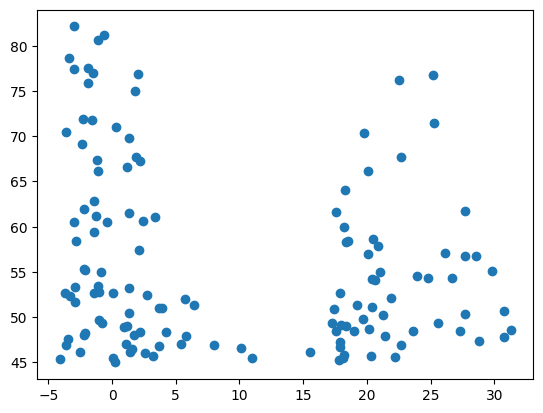

In [128]:
weather_2023 = weather_aq[(weather_aq['date_time'] >= '2023-01-01') & (weather_aq['date_time'] <= '2023-12-01')&(weather_aq.pm10>=45)]
x = weather_2023.temp_C.tolist()
y_3 = weather_2023.pm10.tolist()
plt.scatter(x,y_3)
plt.show()

NB: There are no instances where co levels breach the WHO guidelines of 4000mg/m3 so there is no visualisation for this pollutant.

**Analysis**

- There are 2 peaks for pm2, pm10 and no2, both at high and low temperatures. This could be due to more cars being on the road in lower temperatures
- Generally ozone levels go up as the temperature increases (as we saw from the heatmap)

## Analysis of traffic data (data obtained from Department for transport) 

https://roadtraffic.dft.gov.uk/manualcountpoints/48146

In [129]:
traffic_data = pd.read_csv('data_unclean/traffic_data_2021.csv')
traffic_data.head(10)

,count_point_id,direction_of_travel,year,count_date,hour,region_id,region_name,local_authority_id,local_authority_name,road_name,...,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles
0,48146,E,2021,2021-11-02,7,6,London,146,Hammersmith and Fulham,A306,...,30,227,46,4,8,1,0,3,62,1054
1,48146,E,2021,2021-11-02,8,6,London,146,Hammersmith and Fulham,A306,...,22,204,40,5,7,3,0,3,58,1112
2,48146,E,2021,2021-11-02,9,6,London,146,Hammersmith and Fulham,A306,...,18,174,48,4,14,0,0,4,70,1121
3,48146,E,2021,2021-11-02,10,6,London,146,Hammersmith and Fulham,A306,...,21,127,45,1,10,1,0,5,62,896
4,48146,E,2021,2021-11-02,11,6,London,146,Hammersmith and Fulham,A306,...,18,147,34,3,10,0,1,2,50,906
5,48146,E,2021,2021-11-02,12,6,London,146,Hammersmith and Fulham,A306,...,18,124,27,0,12,2,1,1,43,773
6,48146,E,2021,2021-11-02,13,6,London,146,Hammersmith and Fulham,A306,...,24,106,27,1,9,1,1,3,42,744
7,48146,E,2021,2021-11-02,14,6,London,146,Hammersmith and Fulham,A306,...,17,70,18,1,5,0,0,0,24,599
8,48146,E,2021,2021-11-02,15,6,London,146,Hammersmith and Fulham,A306,...,22,80,10,0,6,2,0,0,18,654
9,48146,E,2021,2021-11-02,16,6,London,146,Hammersmith and Fulham,A306,...,26,79,6,0,6,0,0,0,12,766


In [130]:
traffic_data.columns

Index(['count_point_id', 'direction_of_travel', 'year', 'count_date', 'hour',
       'region_id', 'region_name', 'local_authority_id',
       'local_authority_name', 'road_name', 'road_type',
       'start_junction_road_name', 'end_junction_road_name', 'easting',
       'northing', 'latitude', 'longitude', 'link_length_km',
       'link_length_miles', 'pedal_cycles', 'two_wheeled_motor_vehicles',
       'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'hgvs_2_rigid_axle',
       'hgvs_3_rigid_axle', 'hgvs_4_or_more_rigid_axle',
       'hgvs_3_or_4_articulated_axle', 'hgvs_5_articulated_axle',
       'hgvs_6_articulated_axle', 'all_hgvs', 'all_motor_vehicles'],
      dtype='object')

In [131]:
traffic_data = traffic_data.drop(columns =['count_point_id','direction_of_travel', 'year','region_id', 'region_name', 'local_authority_id',
       'local_authority_name', 'road_name', 'road_type', 'start_junction_road_name', 'end_junction_road_name', 'easting',
       'northing', 'latitude', 'longitude', 'link_length_km',
       'link_length_miles'])

In [132]:
traffic_data.head(10)

,count_date,hour,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles
0,2021-11-02,7,94,60,675,30,227,46,4,8,1,0,3,62,1054
1,2021-11-02,8,144,61,767,22,204,40,5,7,3,0,3,58,1112
2,2021-11-02,9,57,34,825,18,174,48,4,14,0,0,4,70,1121
3,2021-11-02,10,19,35,651,21,127,45,1,10,1,0,5,62,896
4,2021-11-02,11,21,27,664,18,147,34,3,10,0,1,2,50,906
5,2021-11-02,12,14,26,562,18,124,27,0,12,2,1,1,43,773
6,2021-11-02,13,19,30,542,24,106,27,1,9,1,1,3,42,744
7,2021-11-02,14,14,30,458,17,70,18,1,5,0,0,0,24,599
8,2021-11-02,15,16,20,514,22,80,10,0,6,2,0,0,18,654
9,2021-11-02,16,24,26,623,26,79,6,0,6,0,0,0,12,766


In [133]:
traffic_data.count_date = pd.to_datetime(traffic_data.count_date)

In [134]:
traffic_data['date_time'] = traffic_data.apply(lambda row: pd.Timestamp(row['count_date']) + pd.Timedelta(hours=row['hour']), axis=1)

In [135]:
traffic_aq = pd.merge(traffic_data, weather_aq, left_on=['date_time'], right_on=['date_time'], how='left')

In [136]:
traffic_aq.head(20)

,count_date,hour_x,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,...,precipitation,rain,snowfall,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction,day,month,hour_y
0,2021-11-02,7,94,60,675,30,227,46,4,8,...,0.0,0.0,0.0,997.2,8.9,15.9,249,1,11,7
1,2021-11-02,8,144,61,767,22,204,40,5,7,...,0.0,0.0,0.0,997.5,7.9,15.0,240,1,11,8
2,2021-11-02,9,57,34,825,18,174,48,4,14,...,0.0,0.0,0.0,997.7,6.7,12.4,234,1,11,9
3,2021-11-02,10,19,35,651,21,127,45,1,10,...,0.0,0.0,0.0,997.8,7.1,9.3,240,1,11,10
4,2021-11-02,11,21,27,664,18,147,34,3,10,...,0.0,0.0,0.0,997.8,7.4,9.3,241,1,11,11
5,2021-11-02,12,14,26,562,18,124,27,0,12,...,0.0,0.0,0.0,998.1,8.0,9.8,252,1,11,12
6,2021-11-02,13,19,30,542,24,106,27,1,9,...,0.0,0.0,0.0,997.8,7.4,9.2,247,1,11,13
7,2021-11-02,14,14,30,458,17,70,18,1,5,...,0.0,0.0,0.0,997.7,6.0,7.9,253,1,11,14
8,2021-11-02,15,16,20,514,22,80,10,0,6,...,0.0,0.0,0.0,997.6,4.7,6.2,247,1,11,15
9,2021-11-02,16,24,26,623,26,79,6,0,6,...,0.0,0.0,0.0,997.6,5.2,5.8,236,1,11,16


In [137]:
traffic_aq.columns

Index(['count_date', 'hour_x', 'pedal_cycles', 'two_wheeled_motor_vehicles',
       'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'hgvs_2_rigid_axle',
       'hgvs_3_rigid_axle', 'hgvs_4_or_more_rigid_axle',
       'hgvs_3_or_4_articulated_axle', 'hgvs_5_articulated_axle',
       'hgvs_6_articulated_axle', 'all_hgvs', 'all_motor_vehicles',
       'date_time', 'aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10',
       'nh3', 'temp_C', 'percent_humidity', 'precipitation', 'rain',
       'snowfall', 'surface_pressure', 'wind_speed_10m', 'wind_speed_100m',
       'wind_direction', 'day', 'month', 'hour_y'],
      dtype='object')

In [138]:
traffic_aq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   count_date                    24 non-null     datetime64[ns]
 1   hour_x                        24 non-null     int64         
 2   pedal_cycles                  24 non-null     int64         
 3   two_wheeled_motor_vehicles    24 non-null     int64         
 4   cars_and_taxis                24 non-null     int64         
 5   buses_and_coaches             24 non-null     int64         
 6   lgvs                          24 non-null     int64         
 7   hgvs_2_rigid_axle             24 non-null     int64         
 8   hgvs_3_rigid_axle             24 non-null     int64         
 9   hgvs_4_or_more_rigid_axle     24 non-null     int64         
 10  hgvs_3_or_4_articulated_axle  24 non-null     int64         
 11  hgvs_5_articulated_axle       24 n

## Visualisation of traffic and pollutant data

Note: this dataset is limited to one day, so cannot generalise.

In [139]:
traffic_data_by_hour = traffic_aq.groupby('hour_x').all_motor_vehicles.sum()
traffic_data_by_hour = traffic_data_by_hour.to_frame().reset_index()
traffic_data_by_hour = pd.merge(traffic_data_by_hour, traffic_aq, left_on='hour_x', right_on='hour_x', how='left')
traffic_data_by_hour.columns


Index(['hour_x', 'all_motor_vehicles_x', 'count_date', 'pedal_cycles',
       'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches',
       'lgvs', 'hgvs_2_rigid_axle', 'hgvs_3_rigid_axle',
       'hgvs_4_or_more_rigid_axle', 'hgvs_3_or_4_articulated_axle',
       'hgvs_5_articulated_axle', 'hgvs_6_articulated_axle', 'all_hgvs',
       'all_motor_vehicles_y', 'date_time', 'aqi', 'co', 'no', 'no2', 'o3',
       'so2', 'pm2_5', 'pm10', 'nh3', 'temp_C', 'percent_humidity',
       'precipitation', 'rain', 'snowfall', 'surface_pressure',
       'wind_speed_10m', 'wind_speed_100m', 'wind_direction', 'day', 'month',
       'hour_y'],
      dtype='object')

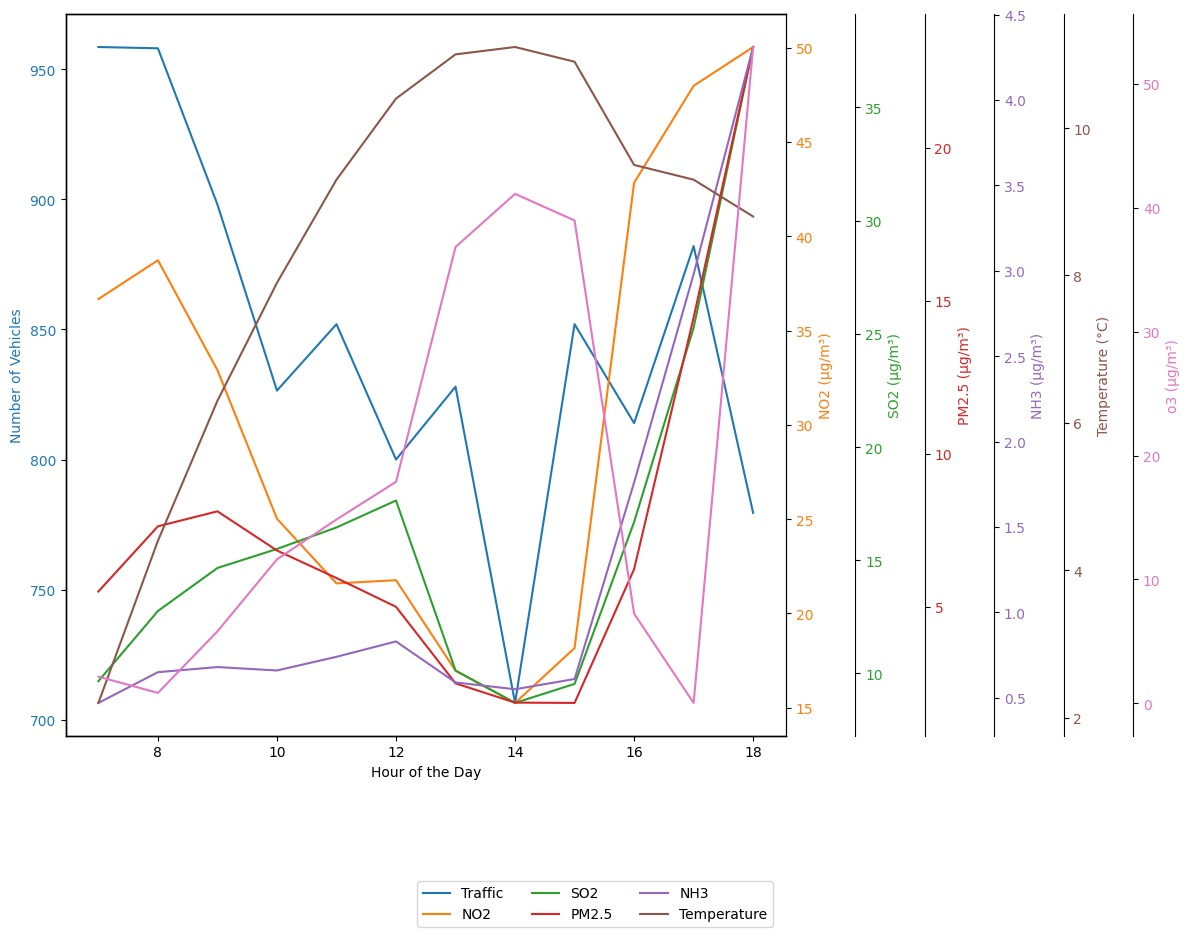

In [140]:
x = traffic_data_by_hour['hour_x']
y_traffic = traffic_data_by_hour['all_motor_vehicles_y']
y_no2 = traffic_data_by_hour['no2']
y_so2 = traffic_data_by_hour['so2']
y_pm2_5 = traffic_data_by_hour['pm2_5']
y_nh3 = traffic_data_by_hour['nh3']
y_temp = traffic_data_by_hour['temp_C']
y_o3 = traffic_data_by_hour['o3']

fig, ax1 = plt.subplots(figsize=(12, 8))

palette = sns.color_palette()

line1 = sns.lineplot(x=x, y=y_traffic, ax=ax1, color=palette[0], label='', errorbar=None)

ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Number of Vehicles', color=palette[0])
ax1.tick_params(axis='y', labelcolor=palette[0])

# Create y-axes for each pollutant
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()
ax5 = ax1.twinx()
ax6 = ax1.twinx()
ax7 = ax1.twinx()

# Offset the right spine of ax3, ax4, ax5, and ax6
ax3.spines['right'].set_position(('outward', 50))
ax4.spines['right'].set_position(('outward', 100))
ax5.spines['right'].set_position(('outward', 150))
ax6.spines['right'].set_position(('outward', 200))
ax7.spines['right'].set_position(('outward', 250))

# Plot each pollutant line and store the line objects
line2 = sns.lineplot(x=x, y=y_no2, ax=ax2, color=palette[1], label='', errorbar=None)
line3 = sns.lineplot(x=x, y=y_so2, ax=ax3, color=palette[2], label='', errorbar=None)
line4 = sns.lineplot(x=x, y=y_pm2_5, ax=ax4, color=palette[3], label='', errorbar=None)
line5 = sns.lineplot(x=x, y=y_nh3, ax=ax5, color=palette[4], label='', errorbar=None)
line6 = sns.lineplot(x=x, y=y_temp, ax=ax6, color=palette[5], label='', errorbar=None)
line7 = sns.lineplot(x=x,y=y_o3, ax=ax7, color=palette[6], label='', errorbar=None)

# Setting labels and colors for each y-axis
ax2.set_ylabel('NO2 (µg/m³)', color=palette[1])
ax2.tick_params(axis='y', labelcolor=palette[1])

ax3.set_ylabel('SO2 (µg/m³)', color=palette[2])
ax3.tick_params(axis='y', labelcolor=palette[2])

ax4.set_ylabel('PM2.5 (µg/m³)', color=palette[3])
ax4.tick_params(axis='y', labelcolor=palette[3])

ax5.set_ylabel('NH3 (µg/m³)', color=palette[4])
ax5.tick_params(axis='y', labelcolor=palette[4])

ax6.set_ylabel('Temperature (°C)', color=palette[5])
ax6.tick_params(axis='y', labelcolor=palette[5])

ax7.set_ylabel('o3 (µg/m³)', color=palette[6])
ax7.tick_params(axis='y', labelcolor=palette[6])

# Create a custom legend
lines = [line1.lines[0], line2.lines[0], line3.lines[0], line4.lines[0], line5.lines[0], line6.lines[0]]
labels = ['Traffic', 'NO2', 'SO2', 'PM2.5', 'NH3', 'Temperature', 'o3']

fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.tight_layout()
plt.show()


**Observations:**
- There is a peak dip in traffic in the middle of the day (at approx 2pm) which causes levels of pollutants (apart from ozone) to drop.


**Potential advice for schools:**
- Keep windows closed wherever possible until 10:00 and after 14:00
- Playtimes and lunchtimes when children are outside should happen between 10 and 14:00
- Take other measures to reduce air pollution (e.g. indoor plants, outdoor planting, air purifiers)

### Analysing vehicle types throughout day

In [141]:
traffic_data_by_hour.iloc[:,:17]

,hour_x,all_motor_vehicles_x,count_date,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles_y,date_time
0,7,1917,2021-11-02,94,60,675,30,227,46,4,8,1,0,3,62,1054,2021-11-02 07:00:00
1,7,1917,2021-11-02,5,11,701,24,101,20,1,2,0,1,2,26,863,2021-11-02 07:00:00
2,8,1916,2021-11-02,144,61,767,22,204,40,5,7,3,0,3,58,1112,2021-11-02 08:00:00
3,8,1916,2021-11-02,17,24,648,22,89,19,1,0,0,1,0,21,804,2021-11-02 08:00:00
4,9,1796,2021-11-02,57,34,825,18,174,48,4,14,0,0,4,70,1121,2021-11-02 09:00:00
5,9,1796,2021-11-02,8,12,490,21,105,33,3,8,2,1,0,47,675,2021-11-02 09:00:00
6,10,1653,2021-11-02,19,35,651,21,127,45,1,10,1,0,5,62,896,2021-11-02 10:00:00
7,10,1653,2021-11-02,4,20,529,14,143,42,1,4,0,1,3,51,757,2021-11-02 10:00:00
8,11,1704,2021-11-02,21,27,664,18,147,34,3,10,0,1,2,50,906,2021-11-02 11:00:00
9,11,1704,2021-11-02,5,12,554,14,157,43,4,7,4,0,3,61,798,2021-11-02 11:00:00


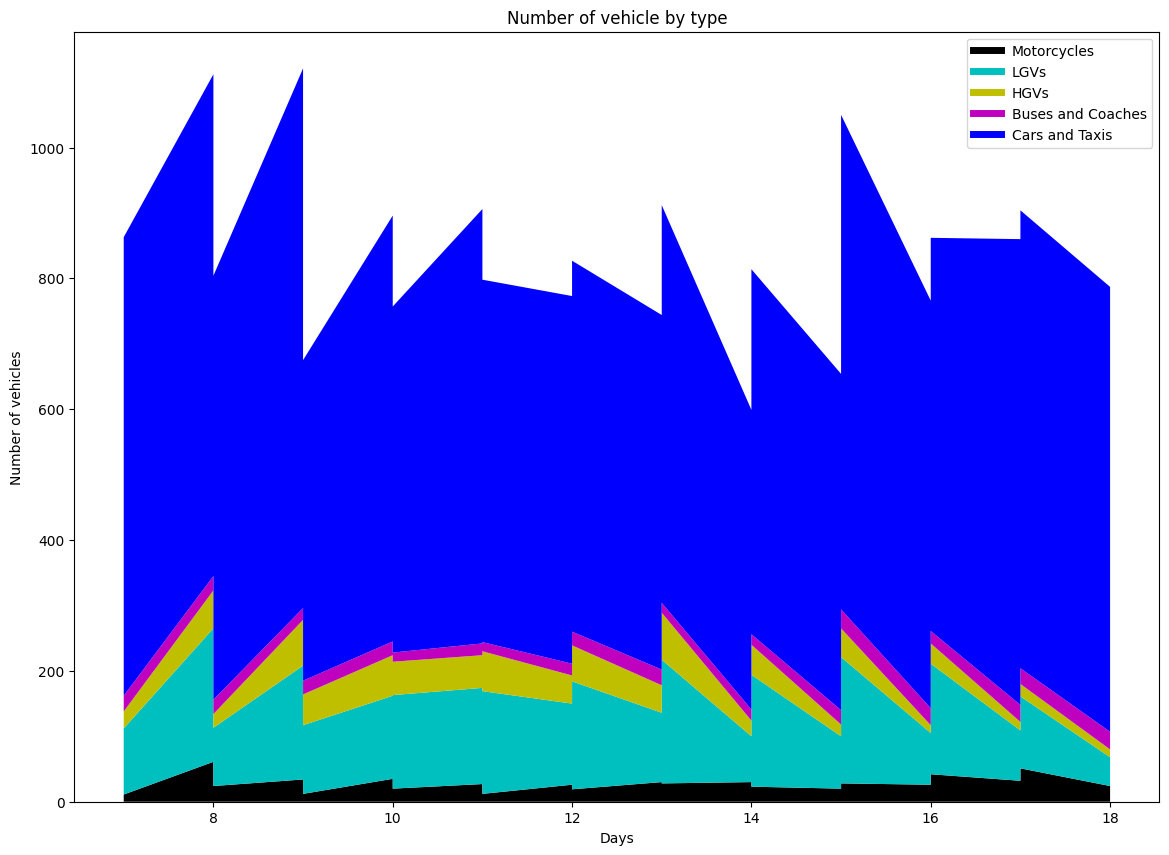

In [142]:

plt.figure(figsize=(14, 10))
x = traffic_data_by_hour['hour_x'].tolist()

# plt.xticks(ticks=x, labels=[str(hour) for hour in x])

y_motorcycles = traffic_data_by_hour['two_wheeled_motor_vehicles'].tolist()
y_lgvs = traffic_data_by_hour['lgvs'].tolist()
y_hgvs = traffic_data_by_hour['all_hgvs'].tolist()
y_bus_coach = traffic_data_by_hour['buses_and_coaches'].tolist()
y_cars_taxis = traffic_data_by_hour['cars_and_taxis'].tolist()
y_total = traffic_data_by_hour['all_motor_vehicles_y'].tolist() 


plt.plot([],[],color='k', label='Motorcycles', linewidth=5)
plt.plot([],[],color='c', label='LGVs', linewidth=5)
plt.plot([],[],color='y', label='HGVs', linewidth=5)
plt.plot([],[],color='m', label='Buses and Coaches', linewidth=5)
plt.plot([],[],color='b', label='Cars and Taxis', linewidth=5)

plt.stackplot(x, y_motorcycles, y_lgvs, y_hgvs, y_bus_coach, y_cars_taxis, colors=['k','c','y','m','b'])

plt.xlabel('Days')
plt.ylabel('Number of vehicles')
plt.title('Number of vehicle by type')

plt.legend()


- Majority of vehicles are cars and taxis
- There is a rise in vehicle use at start and end of day (probably for rush hour)

**Next steps:**
- look at more road traffic data and look at correlation between more traffic/higher pollutants
- Finish comparing alternative data for hammersmith and checking high values are reliable

In [143]:
# This would be good to do if we can gather more road traffic data but currently too limited

# # heatmap to look at correlation between vehicle types and pollutants

# heatmap_data = traffic_data_by_hour.drop(columns=['count_date','date_time', 'temp_C', 'percent_humidity',
#        'precipitation', 'rain', 'snowfall', 'surface_pressure',
#        'wind_speed_10m', 'wind_speed_100m', 'wind_direction', 'day', 'month',
#        'hour_y'])
# plt.figure(figsize = (15,15))
# # correlation_matrix = high_no2.corr()
# correlation_matrix = heatmap_data.corr()
# # seaborn adds heatmap to visually highlight significant values in the matrix
# sns.heatmap(data = correlation_matrix, annot = True)